## Control Variables
- Resolution = 0.25
- ROBOT_RADIUS = 0.25
- REGION = 4
- MAX_SUBGRAPH = 0.5

- Vary num_of agent
- Vary Samples
- Vary Dataset 

### ANN with Optimiser

In [1]:
import BayesianOptimisation.ANNVoronoiDirected as ANNVoronoiDirected
import BayesianOptimisation.experiment_setup as experiment
from core.DataStructure import *

from importlib import reload
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import copy
import itertools

from scipy.optimize import minimize, Bounds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import MinMaxScaler
import os 

np.random.seed(9)
COLOUR = itertools.cycle(['#00FFFF', '#6495ED', '#89CFF0', '#0000FF', '#7393B3', '#088F8F', 
                          '#0096FF', '#0047AB', '#00FFFF', '#00008B', '#6F8FAF',
                          '#1434A4', '#7DF9FF', '#6082B6', '#00A36C', '#5D3FD3',
                          '#ADD8E6'])

In [2]:
# reload(ANNVoronoiDirected)

### Generating Data

In [3]:
# def getCoverage(exp, G, directed = False):
#     total_area = 0
#     total_dist = 0
#     assigned = {}
#     fig, ax = plt.subplots(figsize=(6,6))
#     plt.xlim(0,34)
#     plt.ylim(0,34)
#     count = 0
#     for n in G.nodes:
#         for e in G.neighbors(n):
#             if n != e and frozenset((n, e)) not in assigned.keys():
                
#                 p1 = G.nodes[n]['position']
#                 p2 = G.nodes[e]['position']
                
#                 if (directed):
#                     d = G.edges[n,e,0]['distance']
#                     c = G.edges[n,e,0]['capacity']
#                 else:
#                     d = G.edges[n,e]['distance']
#                     c = G.edges[n,e]['capacity']
                
                
#                 assigned[frozenset((n, e))] = 1

#                 adjustp1 = Point(p1.y, p1.x)
#                 adjustp2 = Point(p2.y, p2.x)

#                 refpt1 = adjustp1 if adjustp1.y <= adjustp2.y else adjustp2
#                 refpt2 = adjustp1 if adjustp1.y > adjustp2.y else adjustp2

#                 if refpt1.x >= refpt2.x:
#                     theta_rot = np.pi - np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))
#                 else:
#                     theta_rot = np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))

#                 if theta_rot >= np.pi/2:
#                     theta = theta_rot - np.pi/2
#                 else:
#                     theta = theta_rot + np.pi/2

#                 dy = -(c/2)*np.sin(theta)
#                 if refpt1.y == refpt2.y:
#                     dx = 0
#                     width = d
#                     height = c
#                     a = 0
#                 elif refpt1.x > refpt2.x:
#                     dx = -(c/2)*np.cos(theta)
#                     width = c
#                     height = d
#                     a = (theta) * 180 / np.pi
#                 elif refpt1.x == refpt2.x:
#                     dx = -(c/2)
#                     width = c
#                     height = d
#                     a = 0
#                 else:
#                     dx = (c/2)*np.cos(np.pi - theta)
#                     width = d
#                     height = c
#                     a = (theta_rot) * 180 / np.pi
                    

#                 rect = Rectangle((refpt1.x+dx,refpt1.y+dy),width,height,linewidth=0.1,fill=True, angle = a,color = 'black')
#                 plt.gca().add_patch(rect)
#                 count +=1

#     for o in exp.obstacles_loc:
#         adjustedx, adjustedy = o[1],o[0]
#         rect = Rectangle((adjustedx-0.5,adjustedy-0.5),1,1,linewidth=0.1,fill=True, angle = 0, color = 'black')
#         plt.gca().add_patch(rect)

#     ax.axis('off')

#     im = fig
#     im.canvas.draw()
#     X = np.array(im.canvas.renderer._renderer)
#     X_reshape = X.reshape((-1,4))
#     X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
#     black = np.count_nonzero(X_reshape == 0)
#     white= np.count_nonzero(X_reshape == 255)
#     print("Black px", black, "White px", white)
#     percentage = black/(white+black)
#     return percentage

In [4]:
# def showAccSolution(result_graph, paths, image, nodes, start_nodes, end_nodes, all_path = True, path_num = 0, save_fig_path = None):
#     edges_in_path = []
#     image2 = 1-image
#     fig, ax = plt.subplots(figsize=(12,12))
#     img = np.array(1-image)
#     ax = sb.heatmap(img)
#     assigned = {}
    
#     for index, path in enumerate(paths):
# #         path = paths[path_num]
#         for ite in range(len(path)-1):
#             edges_in_path.append(np.array([path[ite],path[ite+1],0]))
#             p1 = result_graph.nodes[path[ite]]['position']
#             p2 = result_graph.nodes[path[ite+1]]['position']

#             for r in (p1.x, p2.x, 1):
#                 for c in (p1.y, p2.y, 1):
#                     if (Point(r,c) in np.array(nodes)[end_nodes]):
#                         image2[int(r),int(c)] = 1
#                     else:
#                         image2[int(r),int(c)] += 0.2

#         drawn = {}
#         loop = result_graph.edges if all_path else edges_in_path

#         for elem in loop:
#             cur = result_graph.edges[elem[0], elem[1], 0]['probability']
#             opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
#             unused = 1 - cur - opposite
#             scaler = 0.7
#             if cur > opposite:
#                 p1 = result_graph.nodes[elem[0]]['position']
#                 arr1 = np.array([p1.x,p1.y])
#                 p2 = result_graph.nodes[elem[1]]['position']
#                 arr2 = np.array([p2.x,p2.y])
#                 direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
#                 mag = np.linalg.norm(arr2 - arr1)*scaler
#                 dx, dy = mag*direction
#             else:
#                 p1 = result_graph.nodes[elem[1]]['position']
#                 arr1 = np.array([p1.x,p1.y])
#                 p2 = result_graph.nodes[elem[0]]['position']
#                 arr2 = np.array([p2.x,p2.y])
#                 direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
#                 mag = np.linalg.norm(arr2 - arr1)*scaler
#                 dx, dy = mag*direction
            
#             # only draw arrow once
#             if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys():
#                 plt.arrow(p1.y, p1.x, dy, dx, head_width = 0.35, alpha=0.9, color = 'grey', linewidth=1)
#                 assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
            
# #         p = start_nodes[index]
# #         plt.scatter(nodes[p].y, nodes[p].x, color = 'red', linewidths=5)
# #         p = end_nodes[index]
# #         plt.scatter(nodes[p].y, nodes[p].x, color = 'lime', linewidths=5)
# #         name = './results/vordir_path'+ str(path_num)+'.png'
# #         plt.gca().invert_yaxis()
# #         plt.savefig(name)
        
#     for p in start_nodes:
#         plt.scatter(nodes[p].y, nodes[p].x, color = 'red', linewidths=5)
#     for p in end_nodes:
#         plt.scatter(nodes[p].y, nodes[p].x, color = 'lime', linewidths=5)

# #     name = './data/'+ 'ANN' +'.png'
#     plt.gca().invert_yaxis()
#     plt.savefig(save_fig_path)
#     return fig

In [5]:
# Updated Get Coverage, take into account of obs now
def getCoverage(exp, G, directed = False, save_fig_path = None):
    total_area = 0
    total_dist = 0
    assigned = {}
    fig, ax = plt.subplots(figsize=(6,6))
    plt.xlim(0,exp.image.shape[1])
    plt.ylim(0,exp.image.shape[0])
    count = 0
    
    for o in exp.obstacles_loc:
        adjustedx, adjustedy = o[1],o[0]
        rect = Rectangle((adjustedx-0.5,adjustedy-0.5),1,1,linewidth=0.1,fill=True, angle = 0, color = 'black')
        plt.gca().add_patch(rect)
    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    obs_black = np.count_nonzero(X_reshape == 0)
#     print("Obstacle Black", obs_black)
    
    for n in G.nodes:
        for e in G.neighbors(n):
            if n != e and frozenset((n, e)) not in assigned.keys():
                
                p1 = G.nodes[n]['position']
                p2 = G.nodes[e]['position']
                
                if (directed):
                    d = G.edges[n,e,0]['distance']
                    c = G.edges[n,e,0]['capacity']*exp.ROBOT_RADIUS
                else:
                    d = G.edges[n,e]['distance']
                    c = G.edges[n,e]['capacity']*exp.ROBOT_RADIUS
                
                
                assigned[frozenset((n, e))] = 1

                adjustp1 = Point(p1.y, p1.x)
                adjustp2 = Point(p2.y, p2.x)

                refpt1 = adjustp1 if adjustp1.y <= adjustp2.y else adjustp2
                refpt2 = adjustp1 if adjustp1.y > adjustp2.y else adjustp2

                if refpt1.x >= refpt2.x:
                    theta_rot = np.pi - np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))
                else:
                    theta_rot = np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))

                if theta_rot >= np.pi/2:
                    theta = theta_rot - np.pi/2
                else:
                    theta = theta_rot + np.pi/2

                dy = -(c/2)*np.sin(theta)
                if refpt1.y == refpt2.y:
                    dx = 0
                    width = d
                    height = c
                    a = 0
                elif refpt1.x > refpt2.x:
                    dx = -(c/2)*np.cos(theta)
                    width = c
                    height = d
                    a = (theta) * 180 / np.pi
                elif refpt1.x == refpt2.x:
                    dx = -(c/2)
                    width = c
                    height = d
                    a = 0
                else:
                    dx = (c/2)*np.cos(np.pi - theta)
                    width = d
                    height = c
                    a = (theta_rot) * 180 / np.pi
                    
                print_colour = 'blue' if save_fig_path != None else 'black'
                rect = Rectangle((refpt1.x+dx,refpt1.y+dy),width,height,linewidth=0.1,fill=True, angle = a,color = print_colour )
                plt.gca().add_patch(rect)
                count +=1

    ax.axis('off')
    if save_fig_path != None:
        plt.savefig(save_fig_path)

    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    black = np.count_nonzero(X_reshape == 0)
    white= np.count_nonzero(X_reshape == 255)
#     print("Black px", black, "White px", white)
    percentage = (black-obs_black)/(white+black-obs_black)
#     print("U2", percentage)
    return percentage

In [6]:
def showVorDirSolution(
    result_graph, 
    paths,
    exp,
    save_fig_path = None):
    
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-exp.image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    assigned = {}
    scaler = 0.2
    for elem in result_graph.edges:
        cur = result_graph.edges[elem[0], elem[1], 0]['probability']
        opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
        if cur > opposite:
            p1 = result_graph.nodes[elem[0]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[1]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction
        else:
            p1 = result_graph.nodes[elem[1]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[0]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction

        # only draw arrow once
        if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys():
            head_width = 0.1 if mag < 0.2 else 0.35
            plt.plot([p1.y,p2.y], [p1.x, p2.x],color = "grey", linewidth=1)
            plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = "grey", linewidth=0.1)
            assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
        
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

In [7]:
def showVorDirSolutionPath(
    result_graph, 
    paths, image, 
    nodes, 
    start_nodes, 
    end_nodes, 
    all_path = True, 
    path_num = 0,
    save_fig_path = None):
    
    image2 = 1-image
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    edges_in_path = []
    assigned = {}
    drawn = {}
    
    for index, path in enumerate(paths):
        colour = next(colors)
        for ite in range(len(path)-1):
            edges_in_path.append(np.array([path[ite],path[ite+1],0]))
            p1 = result_graph.nodes[path[ite]]['position']
            p2 = result_graph.nodes[path[ite+1]]['position']

            for r in (p1.x, p2.x, 1):
                for c in (p1.y, p2.y, 1):
                    if (Point(r,c) in np.array(nodes)[end_nodes]):
                        image2[int(r),int(c)] = 1
                    else:
                        image2[int(r),int(c)] += 0.2

        loop = result_graph.edges if all_path else edges_in_path

        for elem in loop:
            cur = result_graph.edges[elem[0], elem[1], 0]['probability']
            opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
            unused = 1 - cur - opposite
            scaler = 0.8
            if cur > opposite:
                p1 = result_graph.nodes[elem[0]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[1]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            else:
                p1 = result_graph.nodes[elem[1]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[0]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            
            # only draw arrow once
            if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
                head_width = 0.1 if mag < 0.2 else 0.35
                plt.plot([p1.y,p2.y], [p1.x, p2.x],color = colour, linewidth=1)
                plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = colour, linewidth=0.1)
                assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
                drawn[frozenset([elem[0], elem[1]])] = 1
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

In [8]:
def showVorDirSolutionAcc(
    result_graph, 
    paths, image, 
    nodes, 
    start_nodes, 
    end_nodes, 
    all_path = True, 
    path_num = 0,
    save_fig_path = None, 
    exp=None):
    
    image2 = 1-image
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-exp.image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    edges_in_path = []
    assigned = {}
    drawn = {}
    
    for index, path in enumerate(paths):
        colour = next(colors)
        for ite in range(len(path)-1):
            edges_in_path.append(np.array([path[ite],path[ite+1],0]))
            p1 = result_graph.nodes[path[ite]]['position']
            p2 = result_graph.nodes[path[ite+1]]['position']

            for r in (p1.x, p2.x, 1):
                for c in (p1.y, p2.y, 1):
                    if (Point(r,c) in np.array(nodes)[end_nodes]):
                        image2[int(r),int(c)] = 1
                    else:
                        image2[int(r),int(c)] += 0.2

        loop = result_graph.edges if all_path else edges_in_path
        for elem in loop:
            cur = result_graph.edges[elem[0], elem[1], 0]['probability']
            opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
            unused = 1 - cur - opposite
            scaler = 0.8
            if cur > opposite:
                p1 = result_graph.nodes[elem[0]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[1]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            else:
                p1 = result_graph.nodes[elem[1]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[0]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            
            # only draw arrow once
            if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
                head_width = 0.1 if mag < 0.2 else 0.35
                plt.plot([p1.y,p2.y], [p1.x, p2.x],color = colour, linewidth=1)
                plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = colour, linewidth=0.1)
                assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
                drawn[frozenset([elem[0], elem[1]])] = 1
                
    #draw all other arrow
    scaler = 0.8
    for elem in result_graph.edges:
        cur = result_graph.edges[elem[0], elem[1], 0]['probability']
        opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
        if cur > opposite:
            p1 = result_graph.nodes[elem[0]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[1]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction
        else:
            p1 = result_graph.nodes[elem[1]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[0]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction

        # only draw arrow once
        if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
            head_width = 0.1 if mag < 0.5 else 0.35
            plt.plot([p1.y,p2.y], [p1.x, p2.x],color = "grey", linewidth=1)
            plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = "grey", linewidth=0.1)
            assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
            drawn[frozenset([elem[0], elem[1]])] = 1
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=120, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=120, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

## Main

In [9]:
results_array = []
OBJECTIVE = "Both"
mapp = 'lak105d'

### Generate all the samples

In [10]:
# # sample_no_list =  [10]
# sample_no_list =  [5000]
# # agent_list = [2]
# agent_list = [4,8]
# final_result_path =  "./data/ANN/final_result.csv"

# for NUM_AGENT in agent_list:
#     for NUM_SAMPLE in sample_no_list:
#         for DATASET in range (2,4,1):
#             try:
#                 overall_path = "./data/ANN/TrainingData/"
#                 os.makedirs(overall_path)
#             except OSError:
#                 print ("Creation of the directory %s failed" % overall_path)
#             else:
#                 print ("Successfully created the directory %s " % overall_path)    
            
#             time_path = "./data/ANN/TrainingData/gather_data_time.csv"
            
#             scene = "./input/same_density/"+ mapp +'/dataset/'+str(DATASET)+'_'+ mapp + ".scen"
#             scenemap = "./input/same_density/"+ mapp +'/'+ mapp + ".map"
#             exp = experiment.Experiment(scenemap=scenemap, scene=scene, objective= OBJECTIVE, num_agent=NUM_AGENT)


#             start = time.time()
#             ANNVoronoiDirected.ann_voronoi_directed(exp, dataset=DATASET, num_sample = NUM_SAMPLE)
#             end = time.time()
#             gather_data_time = end-start
#             print("Finish generating data")
            
#             with open(time_path, 'a+') as f:
#                 df = pd.DataFrame([[NUM_AGENT,NUM_SAMPLE,DATASET,gather_data_time]],columns=['NUM_AGENT','NUM_SAMPLE','DATASET','gather_data_time'])
#                 pd.DataFrame(df).to_csv(f, index=None)



Creation of the directory ./data/ANN/TrainingData/ failed
Set Hyper Parameters, solving for 4 agents
Saving Data to ./data/ANN/TrainingData/Dataset2-Agent4_x_path.csv
total number of distance 185
Finish generating data
Creation of the directory ./data/ANN/TrainingData/ failed
Set Hyper Parameters, solving for 4 agents
Saving Data to ./data/ANN/TrainingData/Dataset3-Agent4_x_path.csv
total number of distance 185
Finish generating data
Creation of the directory ./data/ANN/TrainingData/ failed
Set Hyper Parameters, solving for 8 agents
Saving Data to ./data/ANN/TrainingData/Dataset2-Agent8_x_path.csv
total number of distance 192
Finish generating data
Creation of the directory ./data/ANN/TrainingData/ failed
Set Hyper Parameters, solving for 8 agents
Saving Data to ./data/ANN/TrainingData/Dataset3-Agent8_x_path.csv
total number of distance 192
Finish generating data


### Slicing the dataset to see the impact of the number of samples

Successfully created the directory ./data/ANN/4agent/Samples10/Dataset3/ 
X shape (10, 173)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 4 agents
total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2


/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2
Successfully created the directory ./data/ANN/4agent/Samples50/Dataset3/ 
X shape (50, 173)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 4 agents
total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2

Cannot find complete solution. Some didnt reach goal



/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2

Cannot find complete solution. Some didnt reach goal

Successfully created the directory ./data/ANN/4agent/Samples100/Dataset3/ 
X shape (100, 173)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 4 agents
total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2


/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2
Successfully created the directory ./data/ANN/4agent/Samples500/Dataset3/ 
X shape (500, 173)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 4 agents
total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2


/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2
Successfully created the directory ./data/ANN/4agent/Samples1000/Dataset3/ 
X shape (1000, 173)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 4 agents
total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2


/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2
Successfully created the directory ./data/ANN/4agent/Samples5000/Dataset3/ 
X shape (5000, 173)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 4 agents
total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2

Cannot find complete solution. Some didnt reach goal



/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 185
Number of trainable probabilities 170
Length cutoff threshold 2

Cannot find complete solution. Some didnt reach goal

Successfully created the directory ./data/ANN/8agent/Samples10/Dataset3/ 
X shape (10, 180)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 8 agents
total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2


/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2
Successfully created the directory ./data/ANN/8agent/Samples50/Dataset3/ 
X shape (50, 180)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 8 agents
total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2


/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2
Successfully created the directory ./data/ANN/8agent/Samples100/Dataset3/ 
X shape (100, 180)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 8 agents
total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2

Cannot find complete solution. Some didnt reach goal



/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2

Cannot find complete solution. Some didnt reach goal

Successfully created the directory ./data/ANN/8agent/Samples500/Dataset3/ 
X shape (500, 180)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 8 agents
total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2


/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2
Successfully created the directory ./data/ANN/8agent/Samples1000/Dataset3/ 
X shape (1000, 180)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 8 agents
total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2


/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2
Successfully created the directory ./data/ANN/8agent/Samples5000/Dataset3/ 
X shape (5000, 180)
Start Optimiser
Start Visualise
Set Hyper Parameters, solving for 8 agents
total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2


/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/elim/anaconda3/envs/Research-May/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


total number of distance 192
Number of trainable probabilities 177
Length cutoff threshold 2


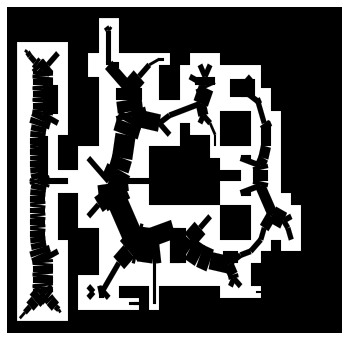

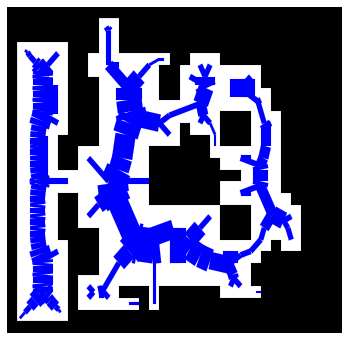

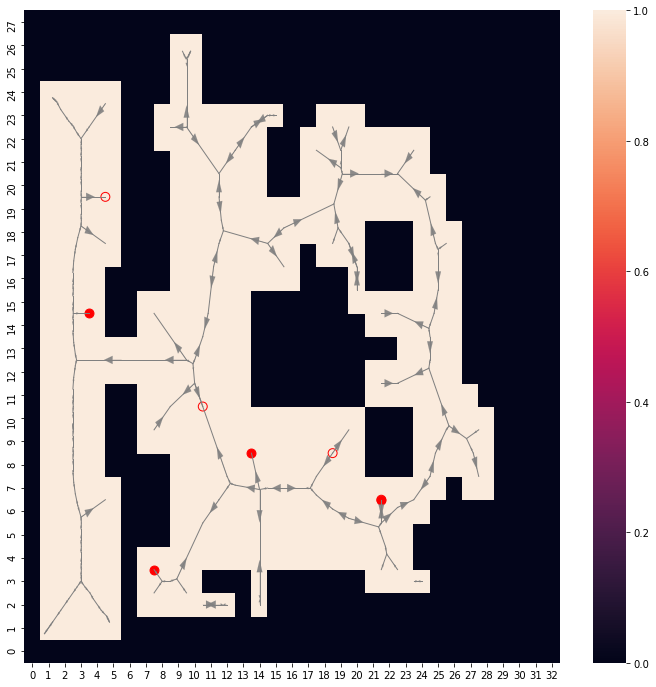

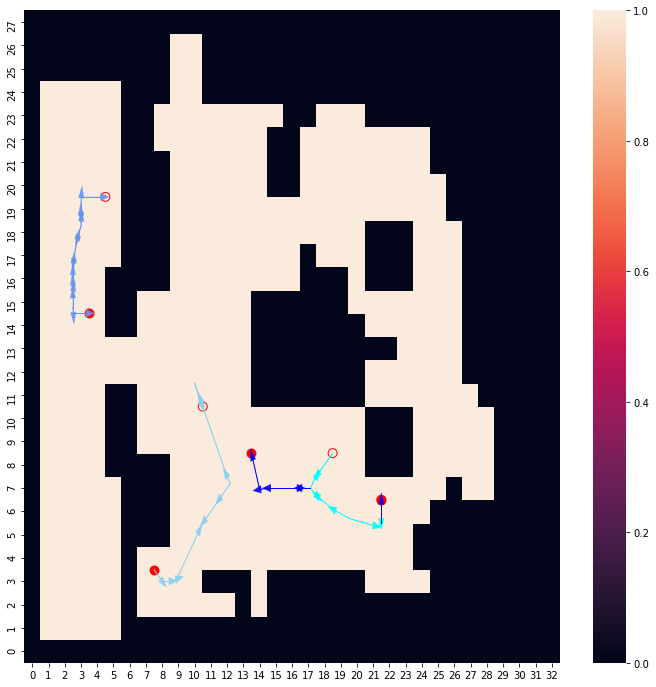

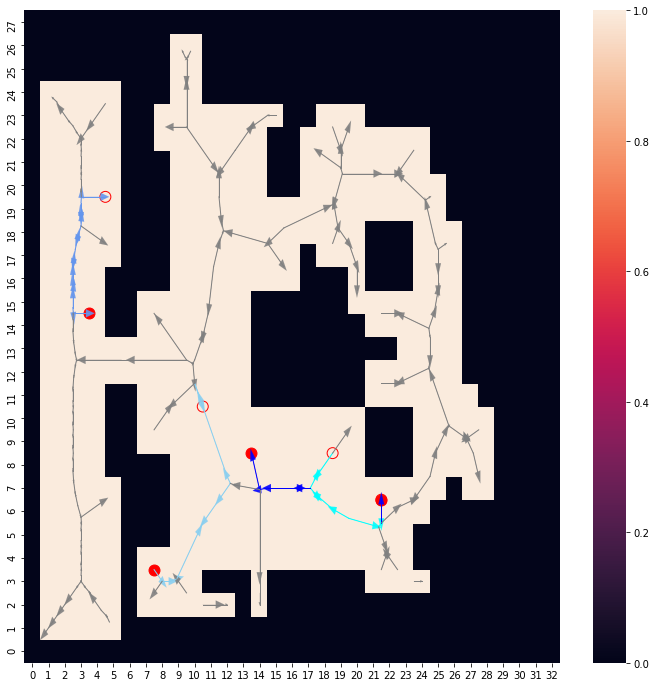

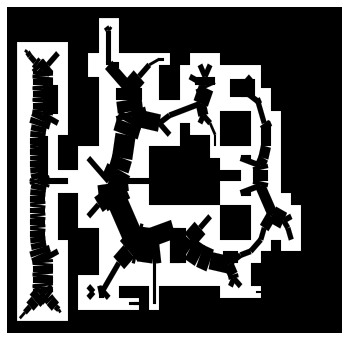

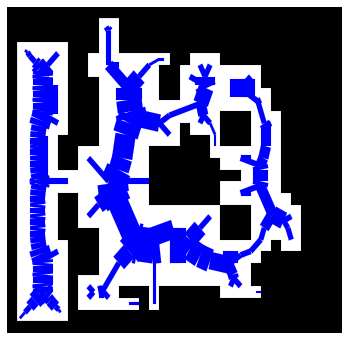

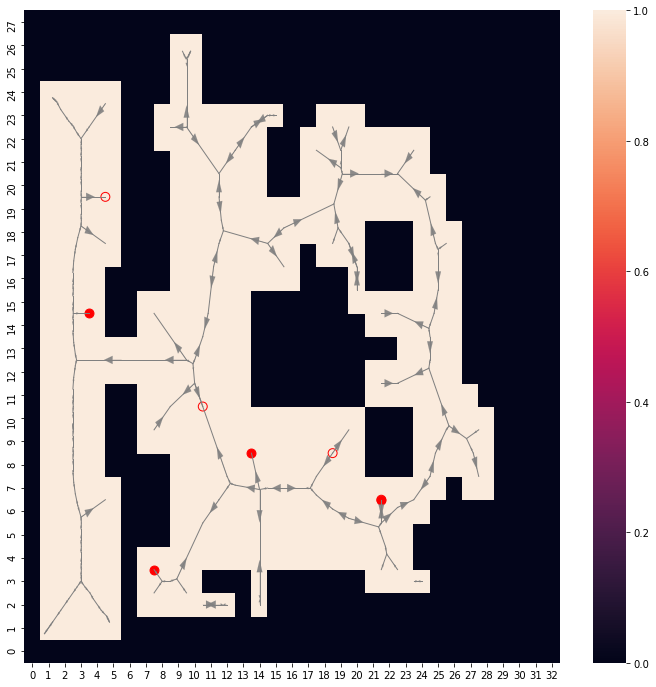

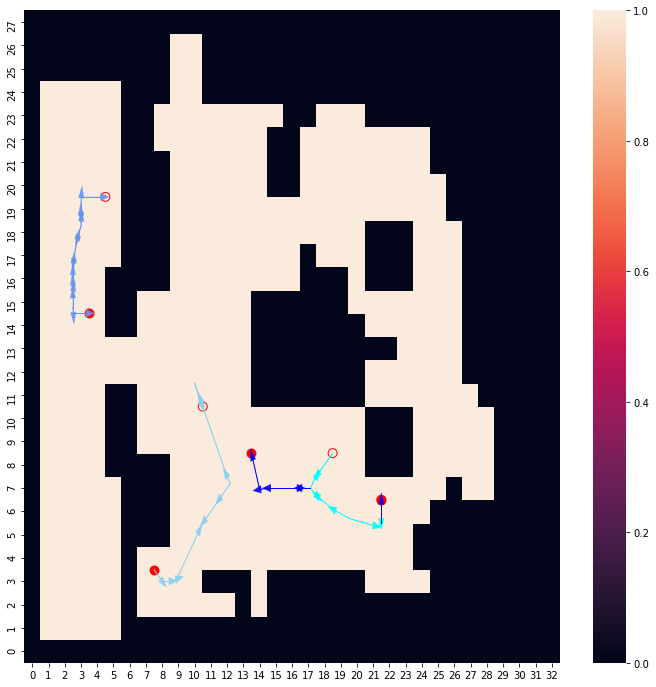

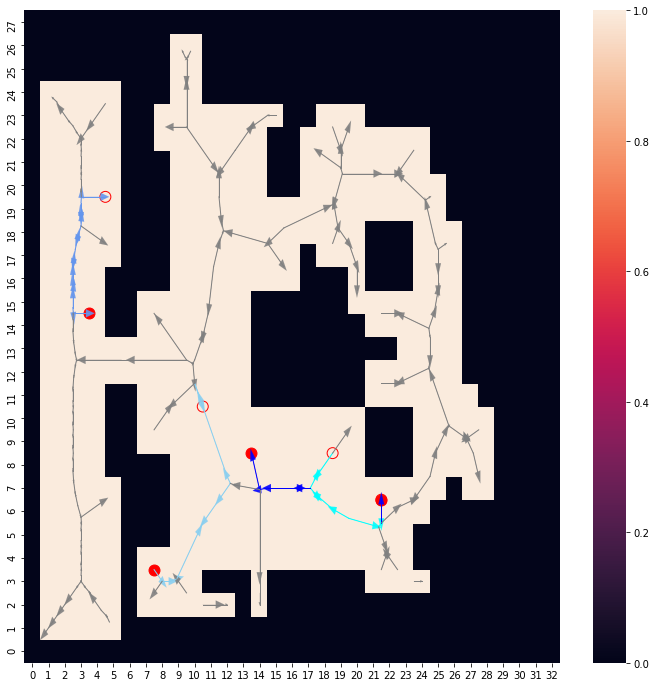

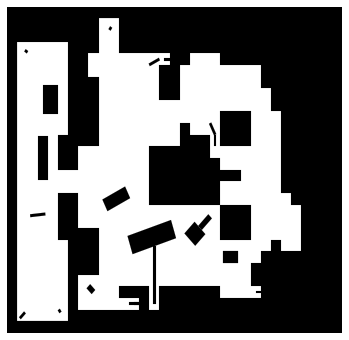

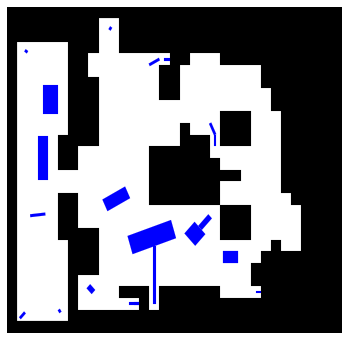

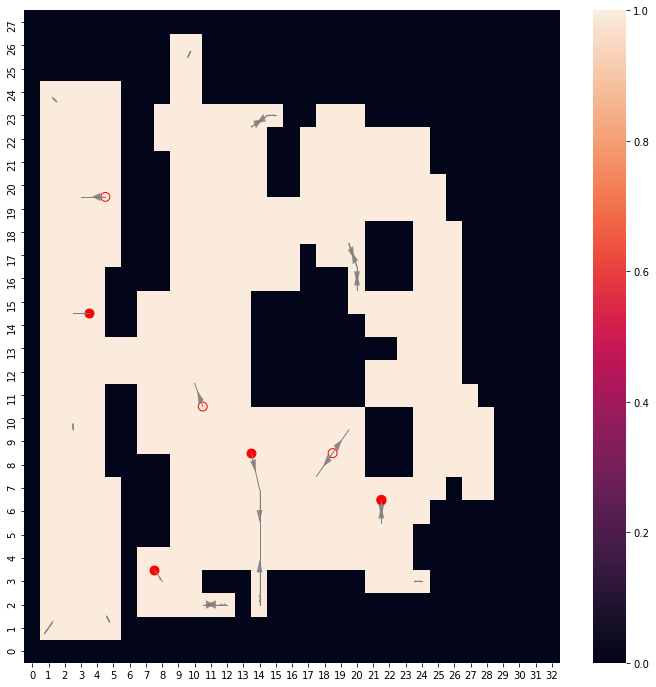

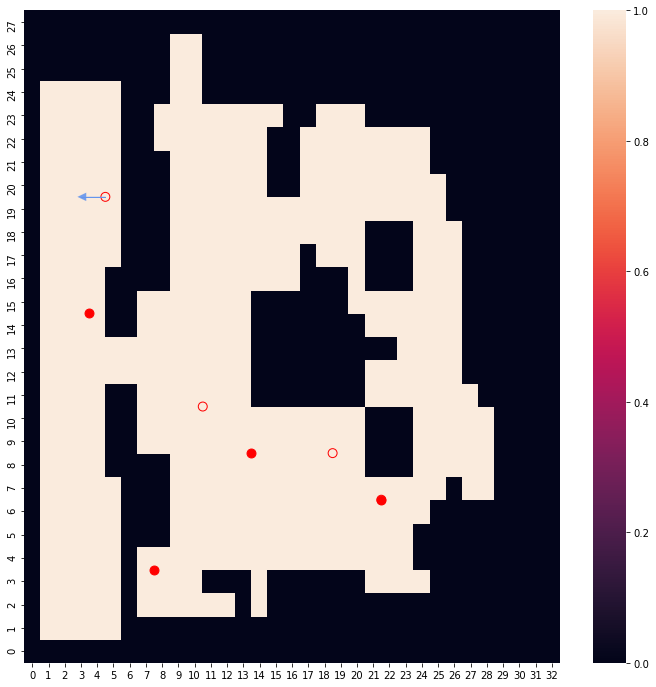

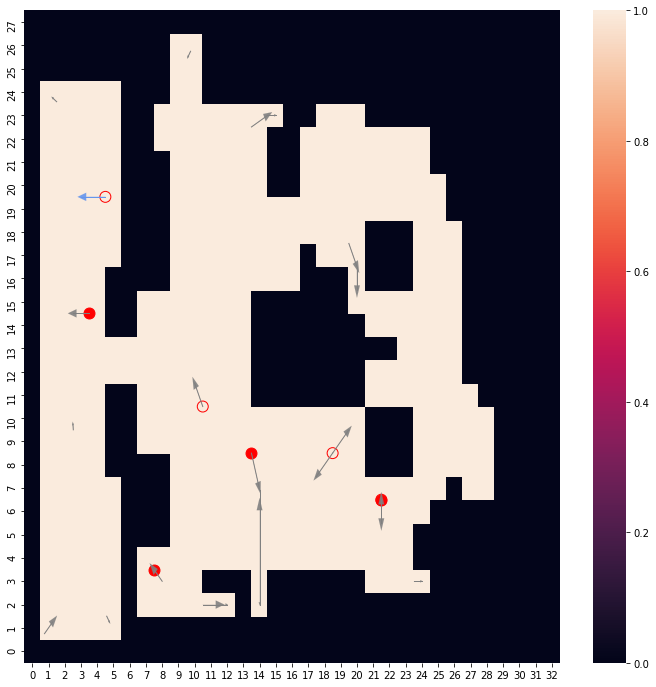

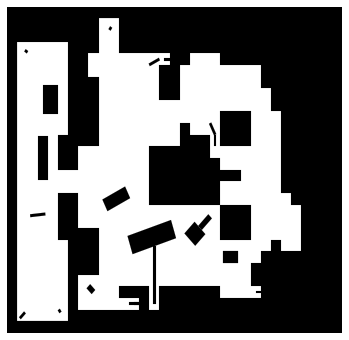

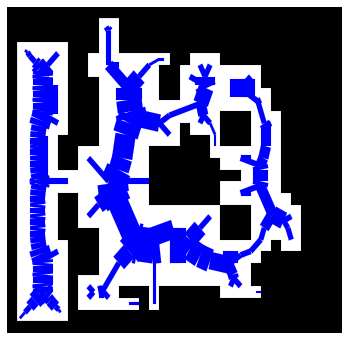

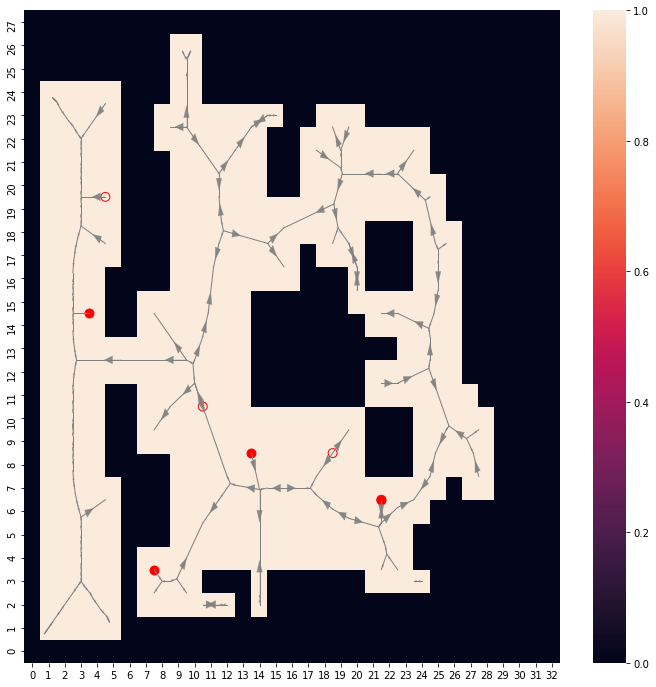

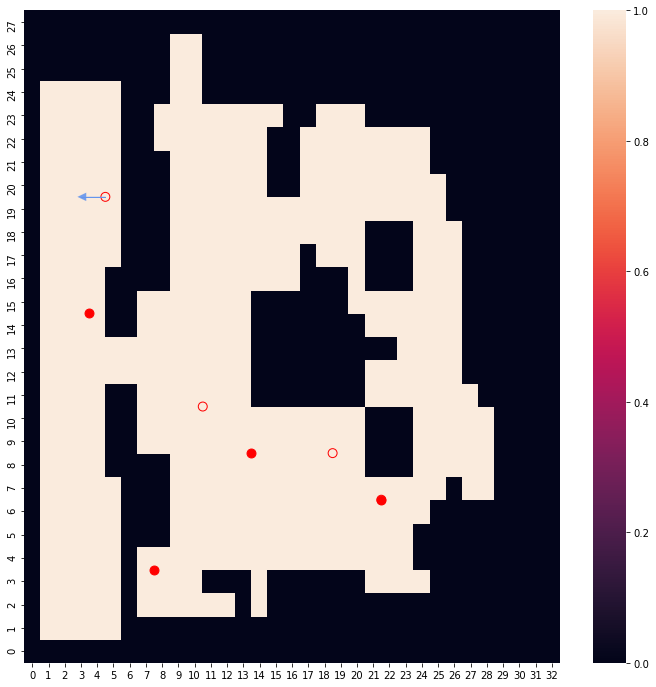

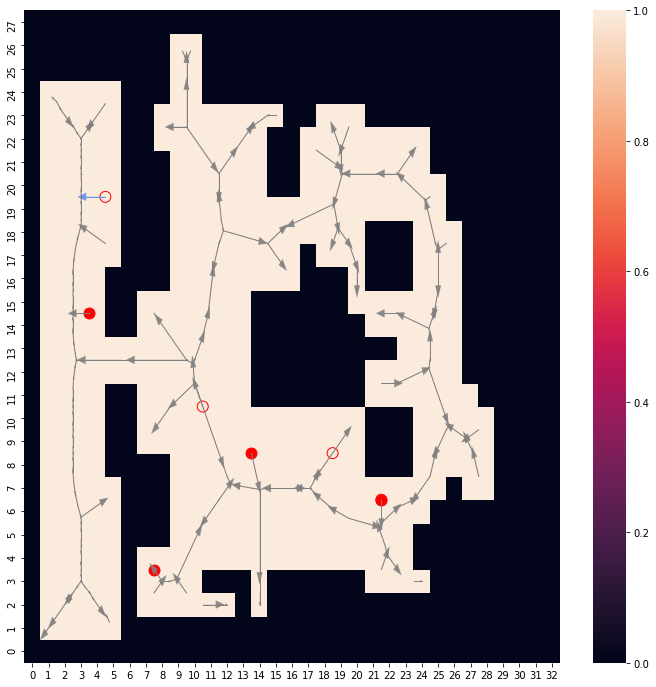

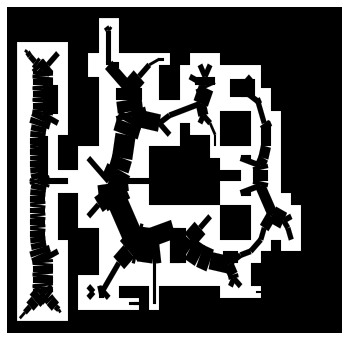

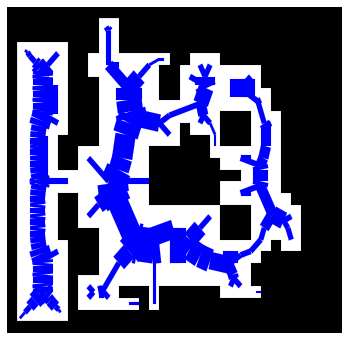

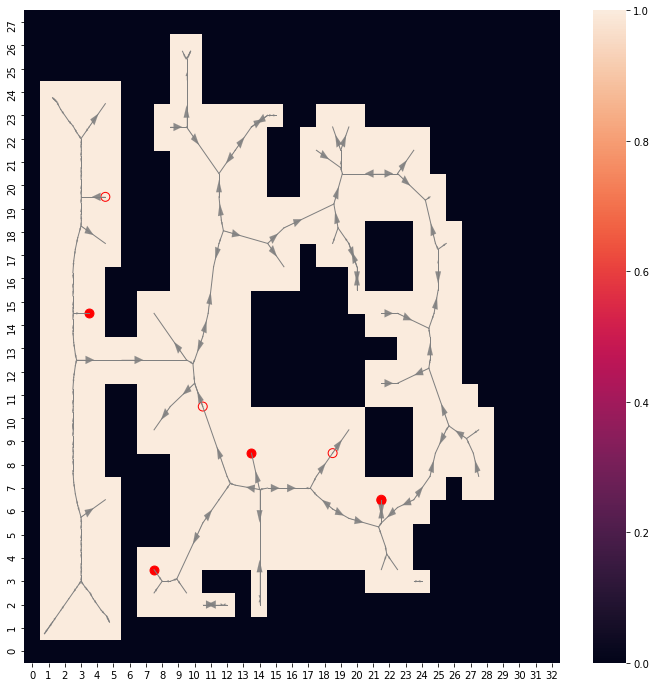

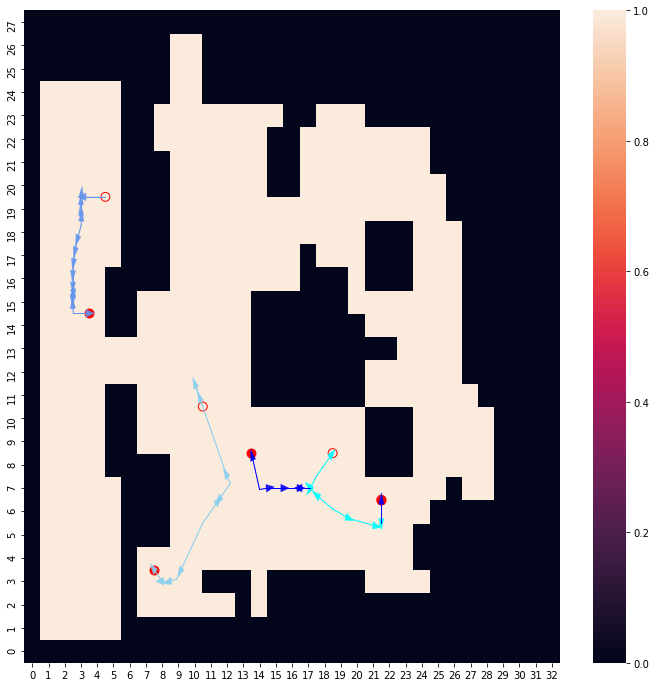

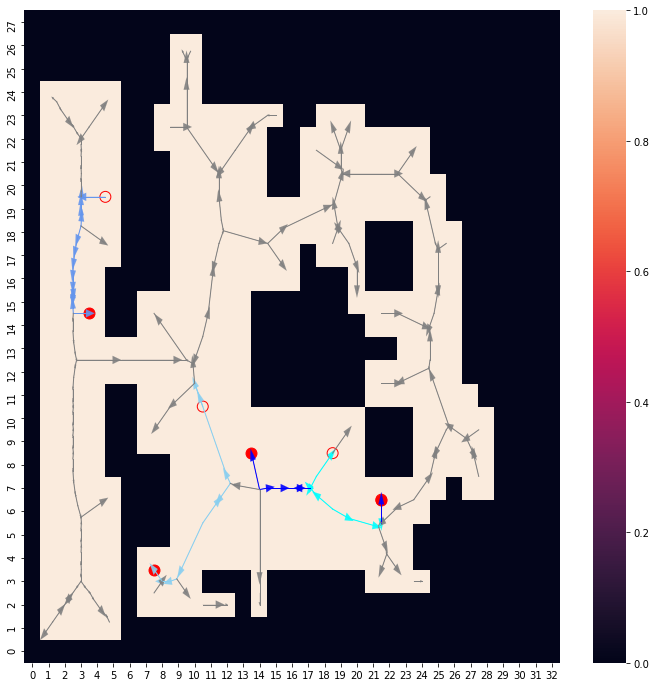

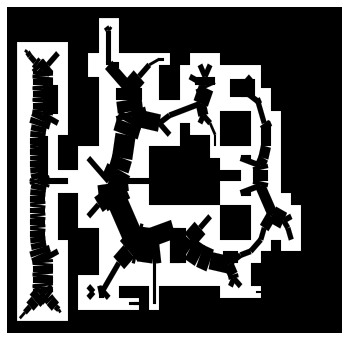

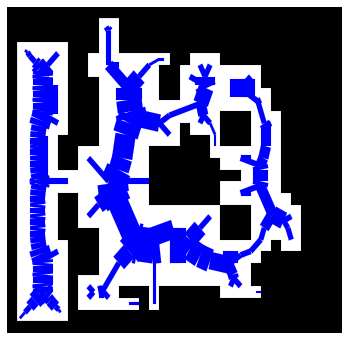

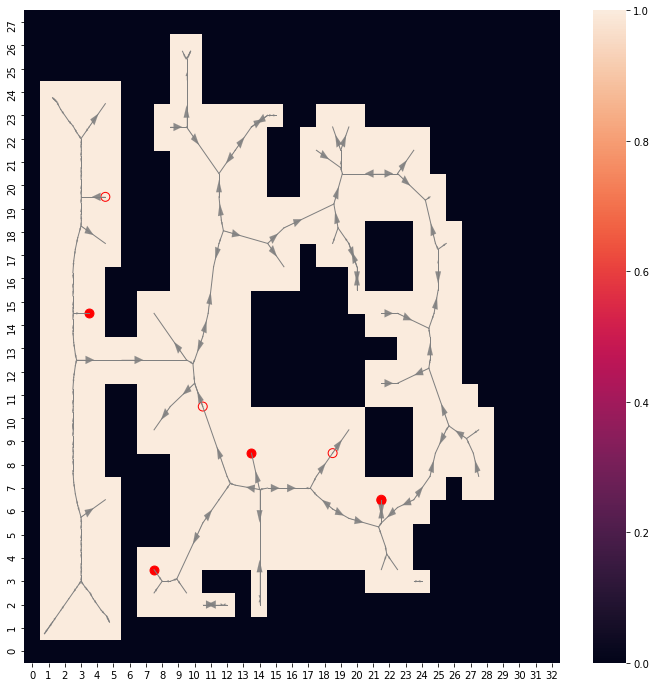

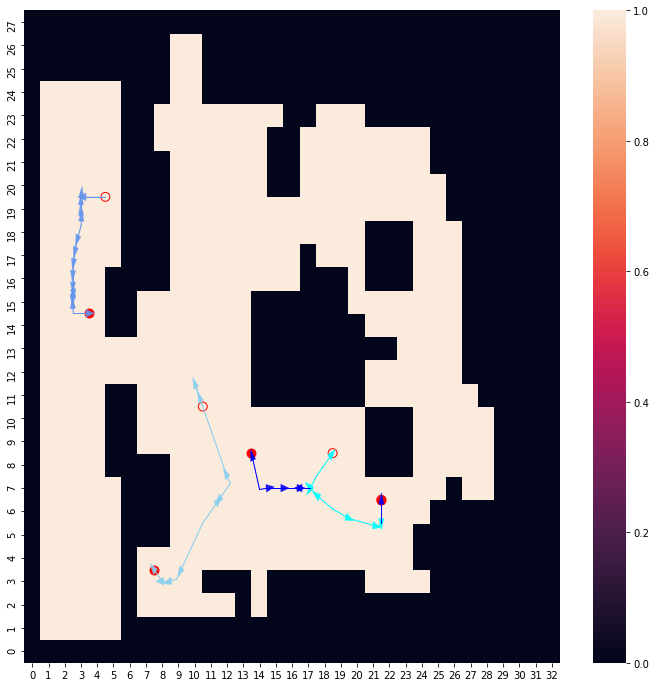

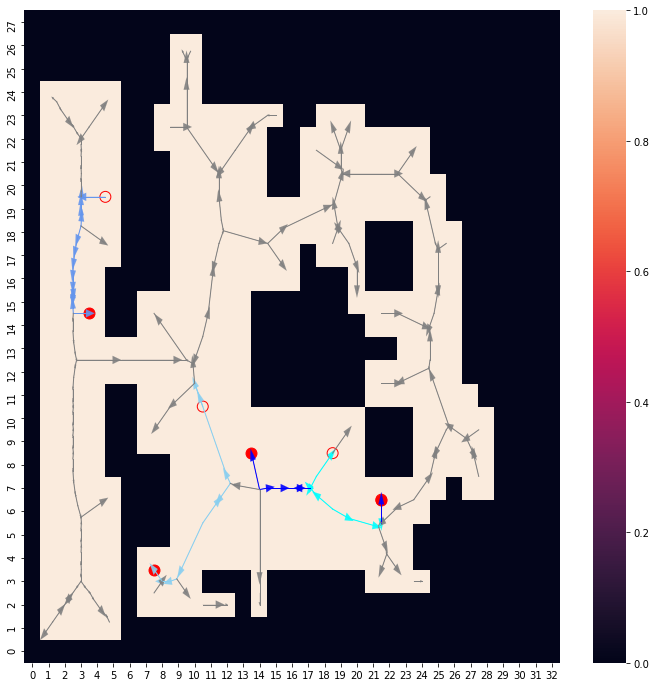

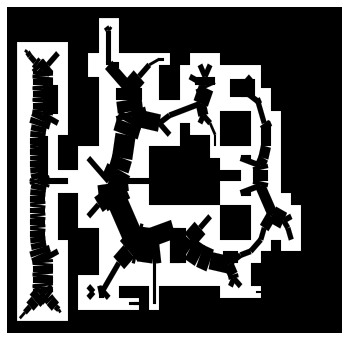

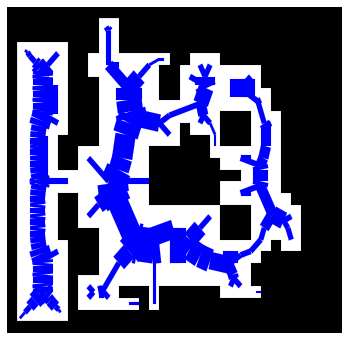

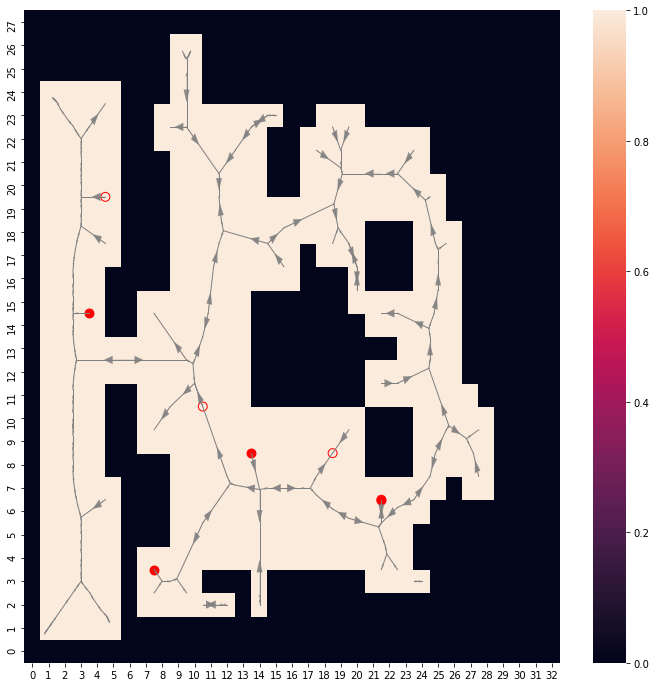

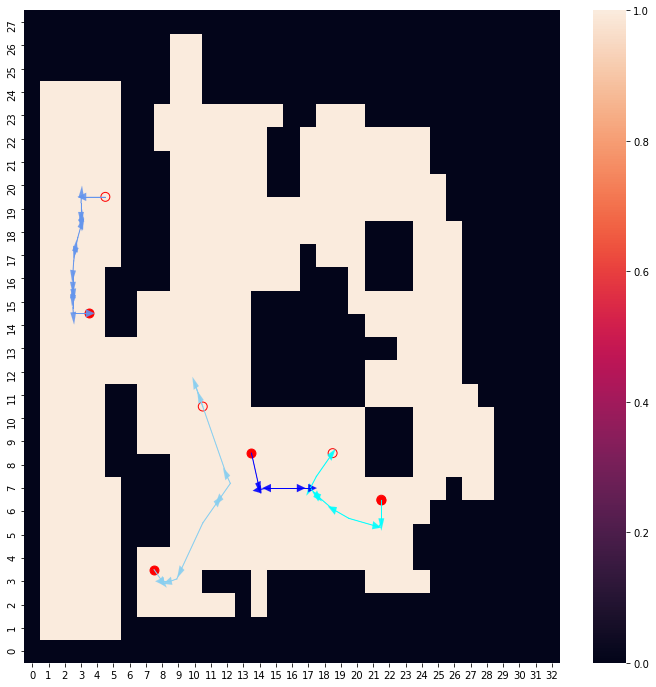

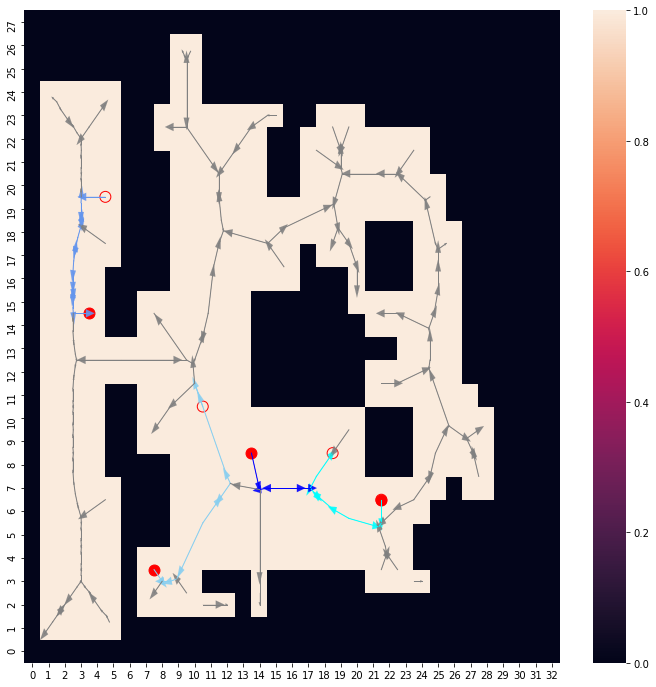

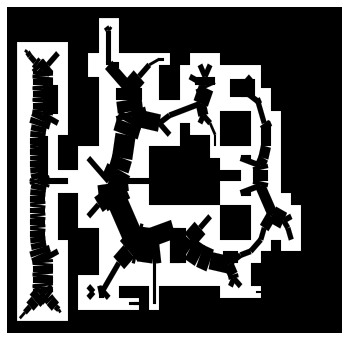

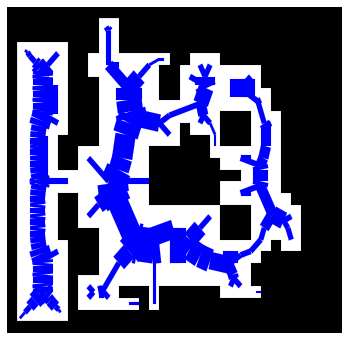

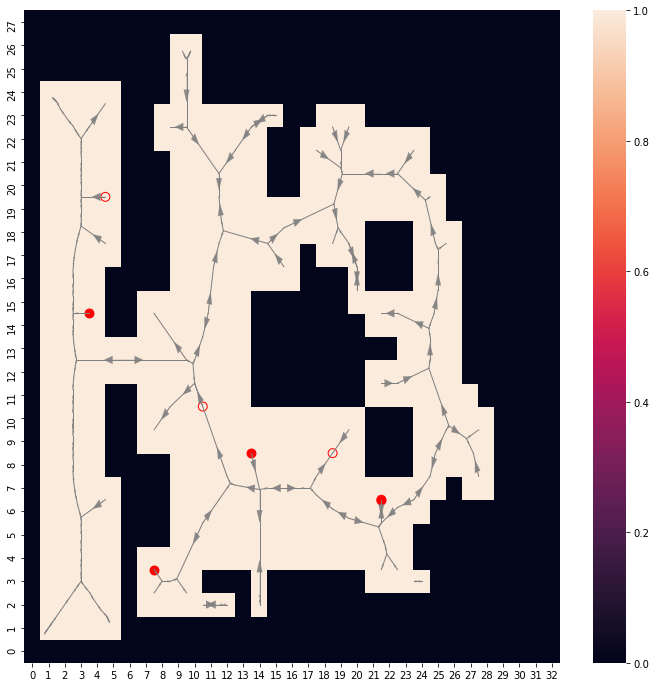

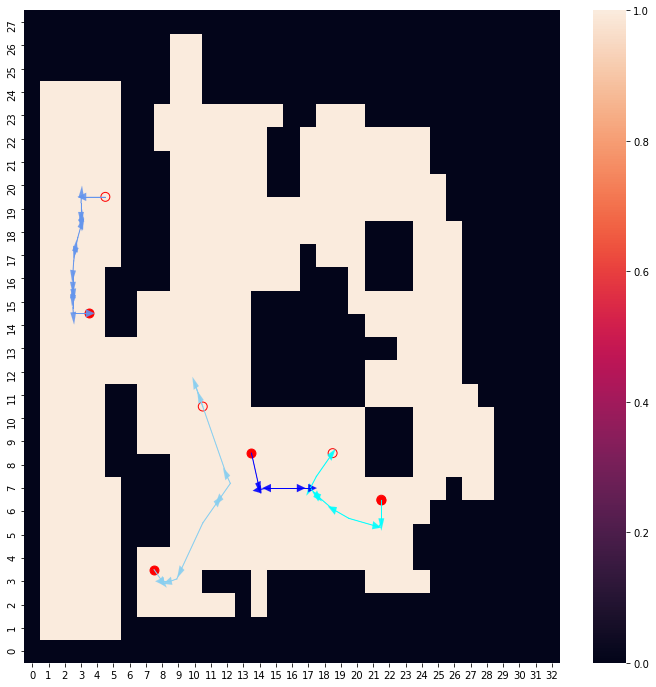

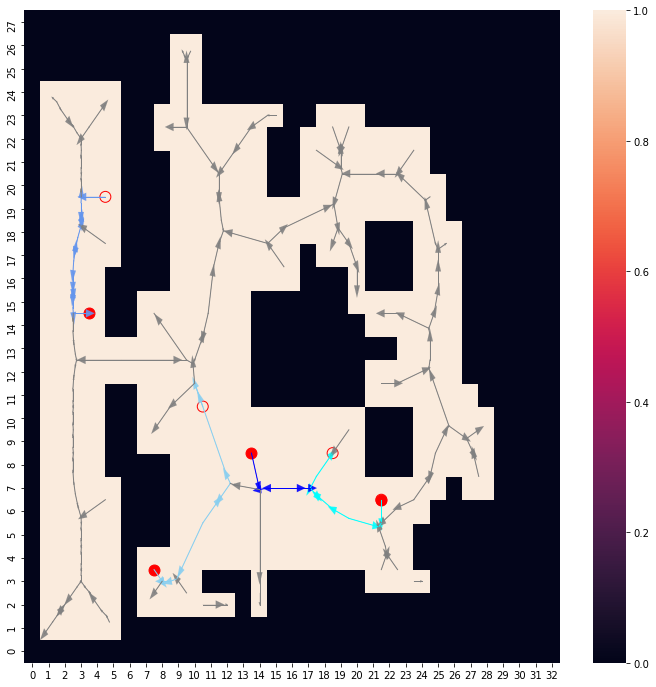

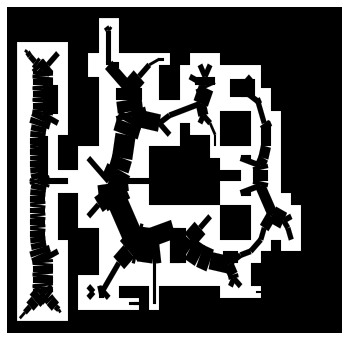

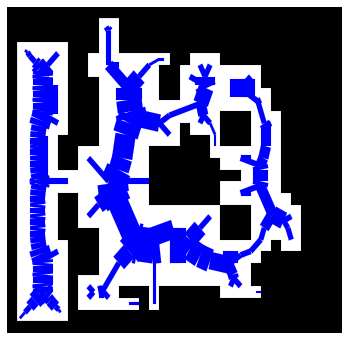

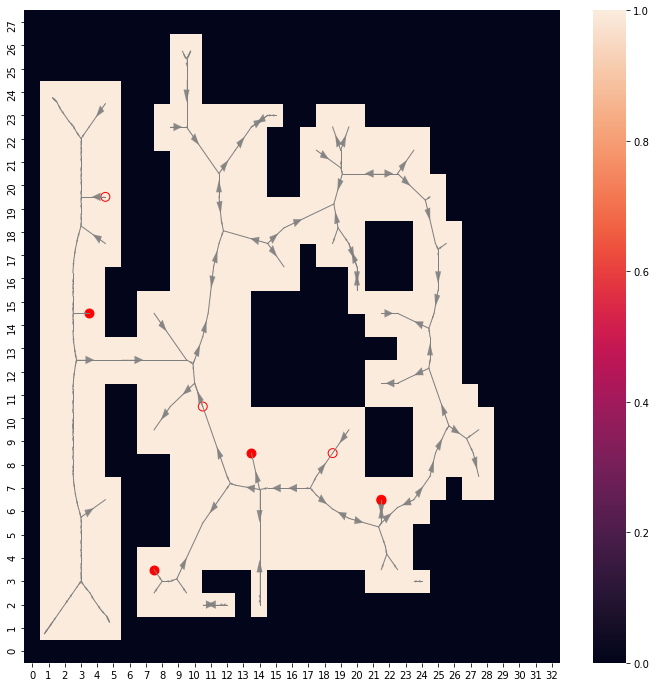

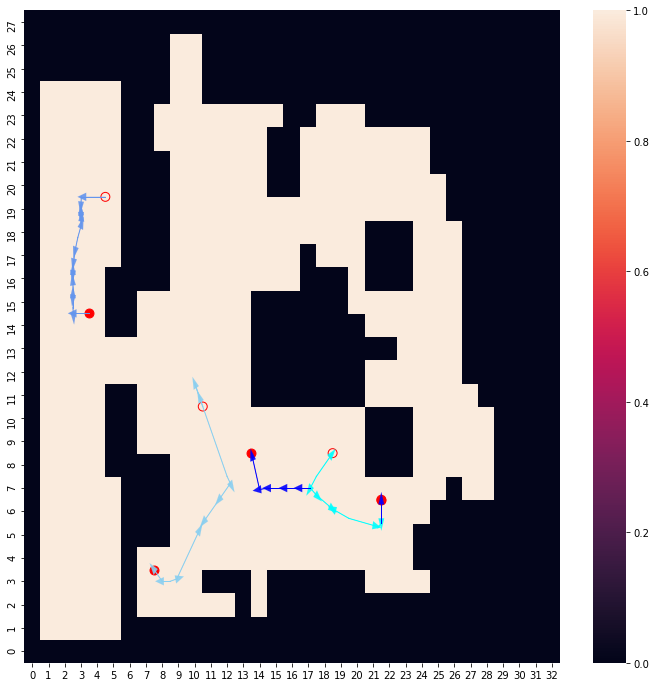

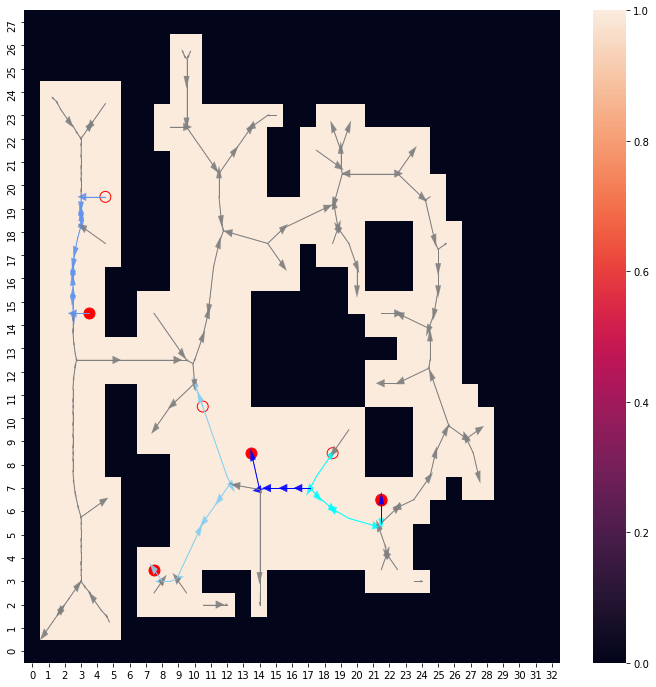

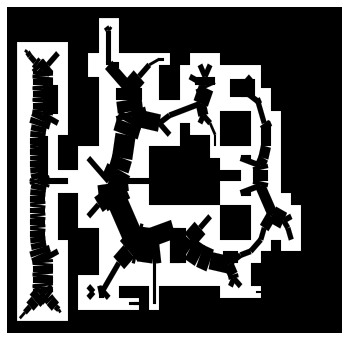

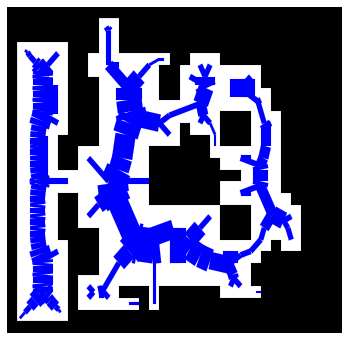

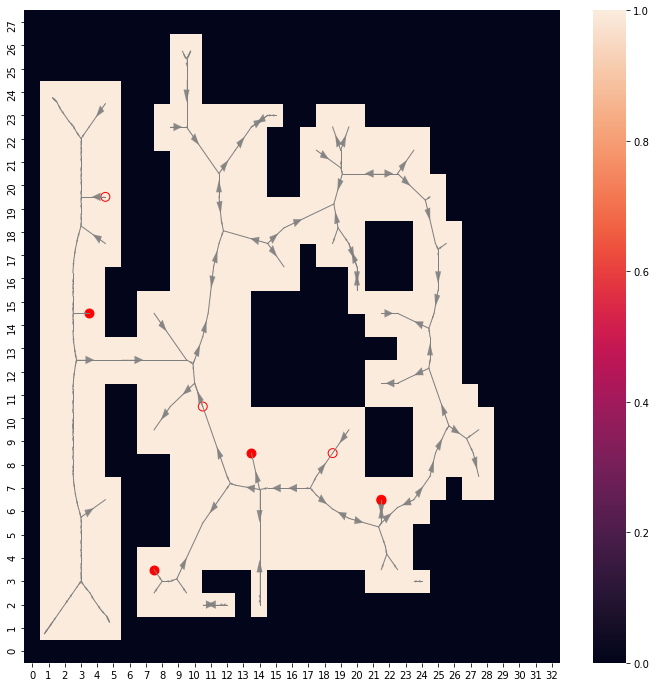

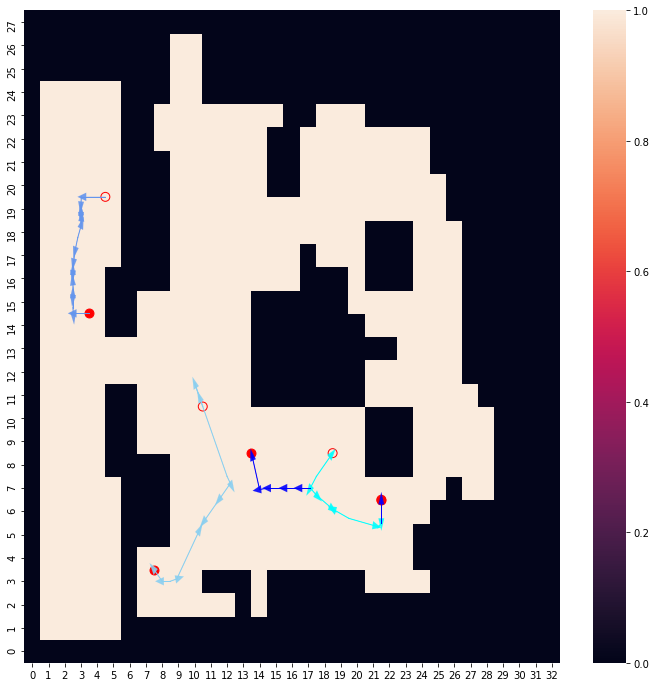

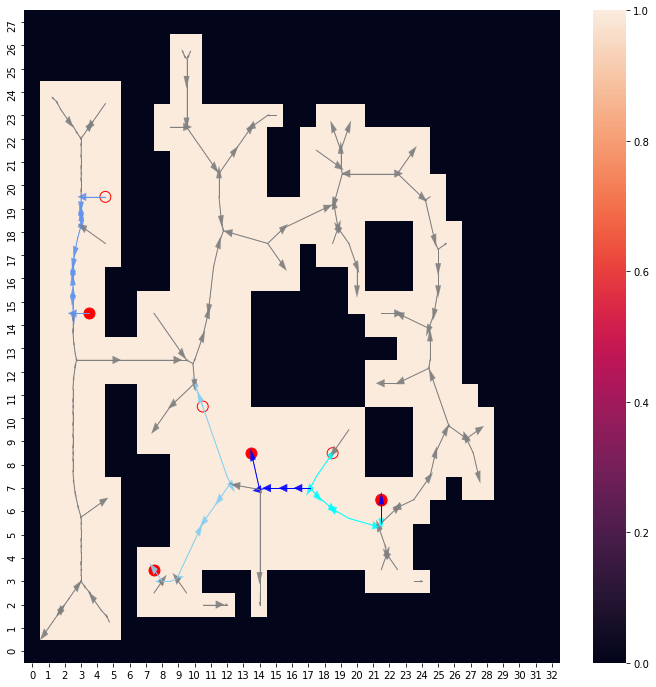

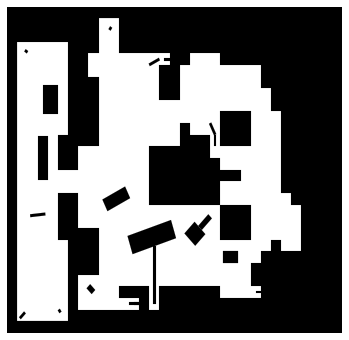

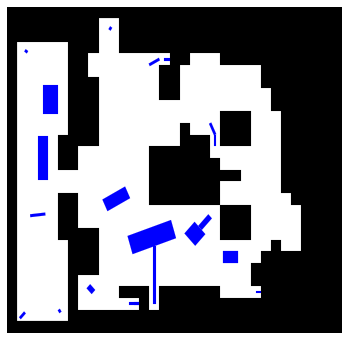

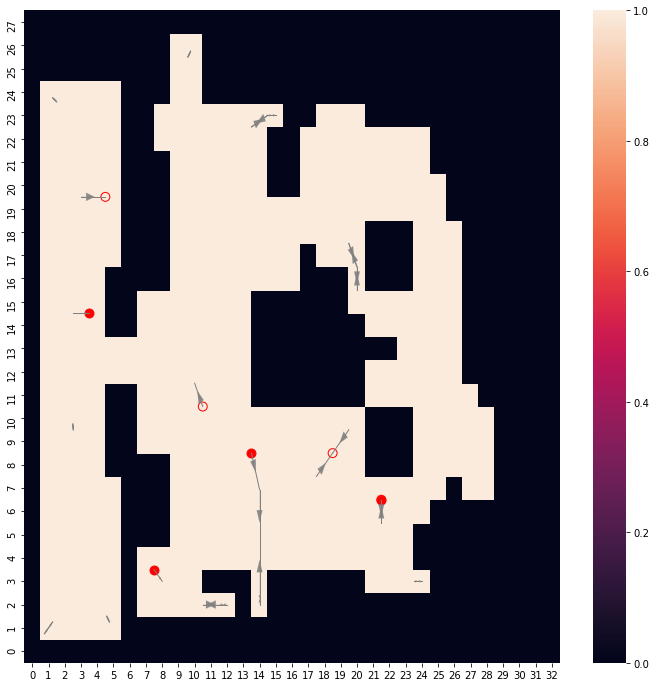

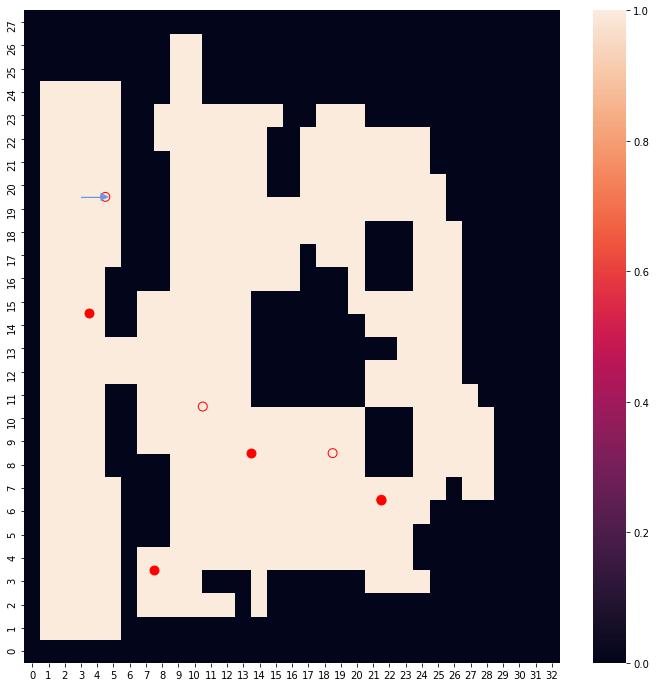

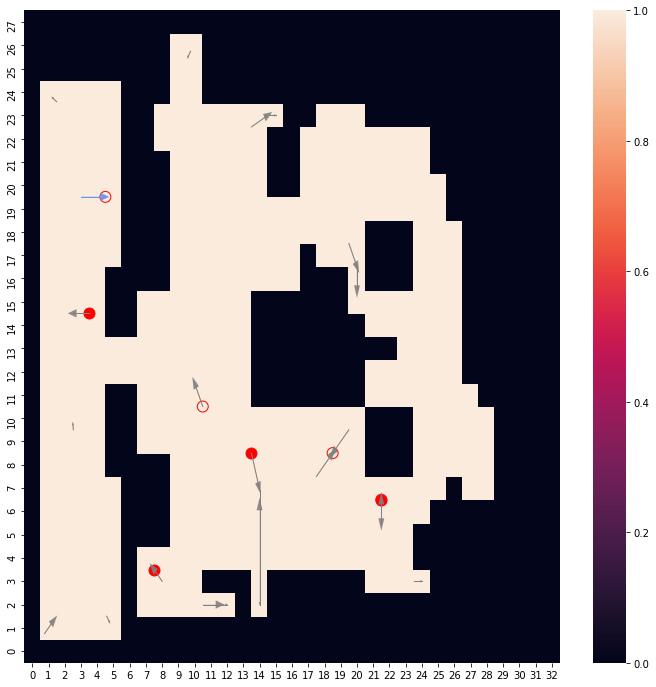

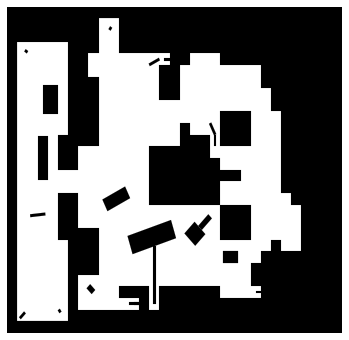

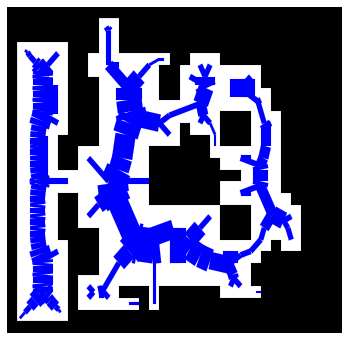

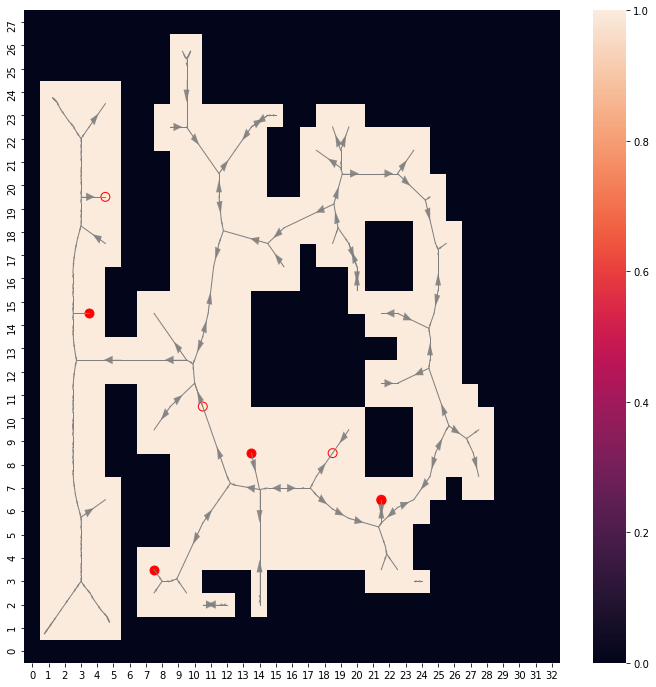

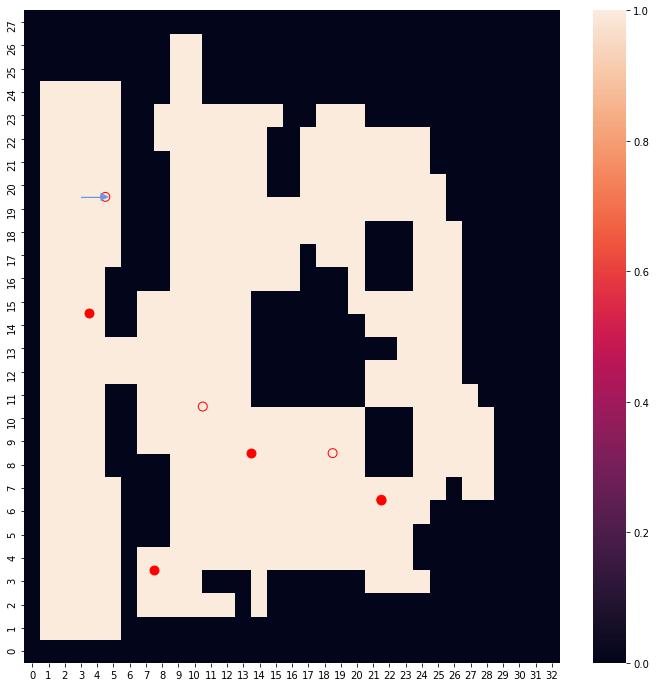

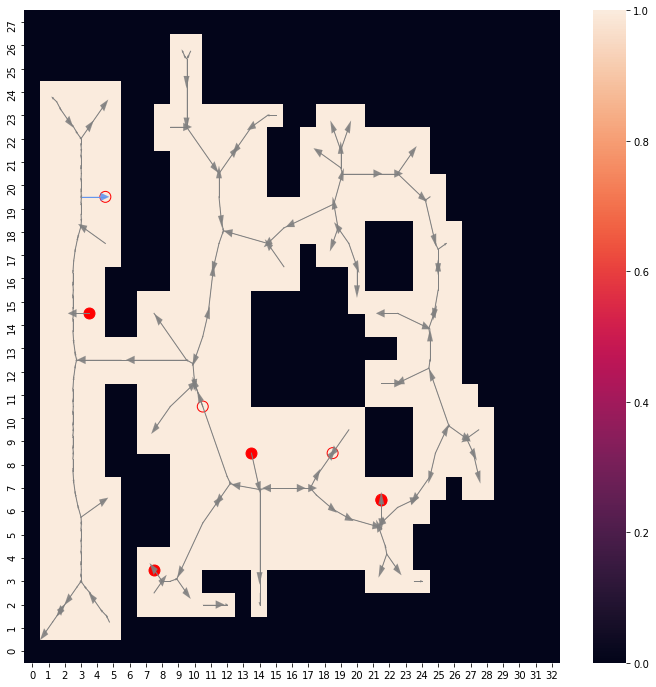

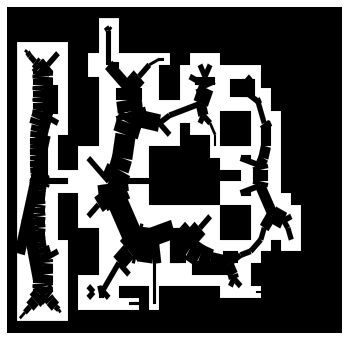

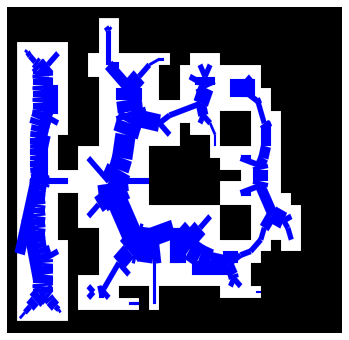

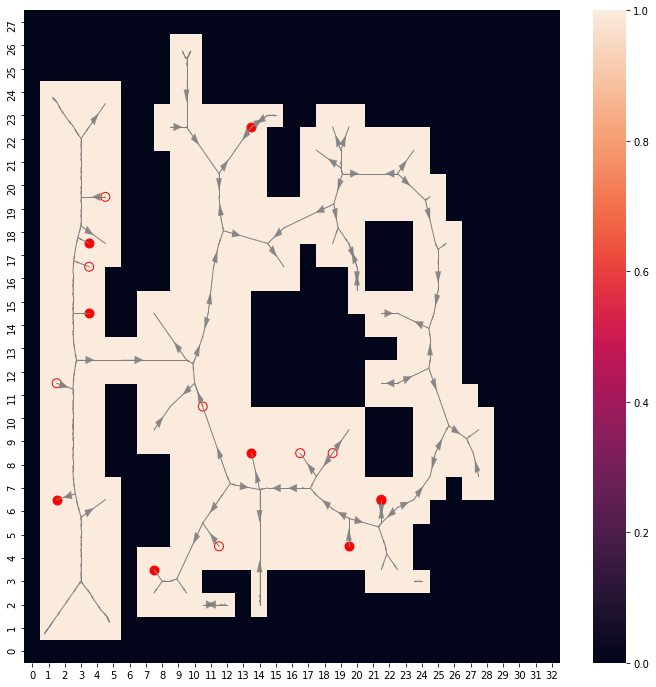

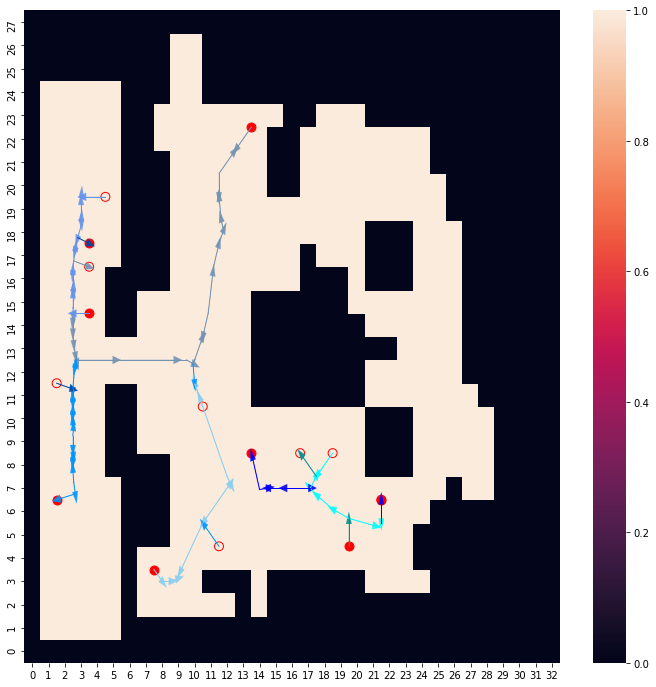

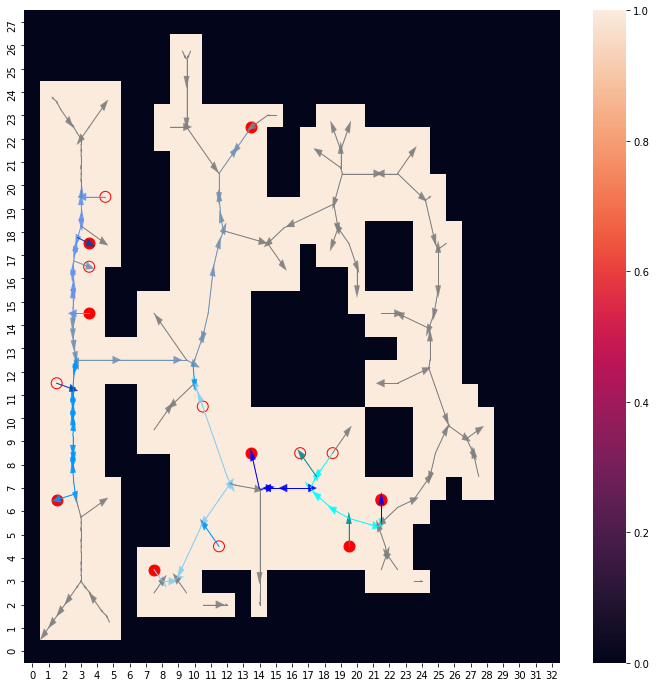

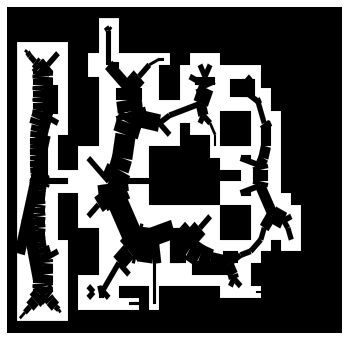

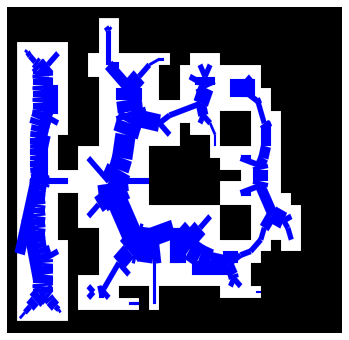

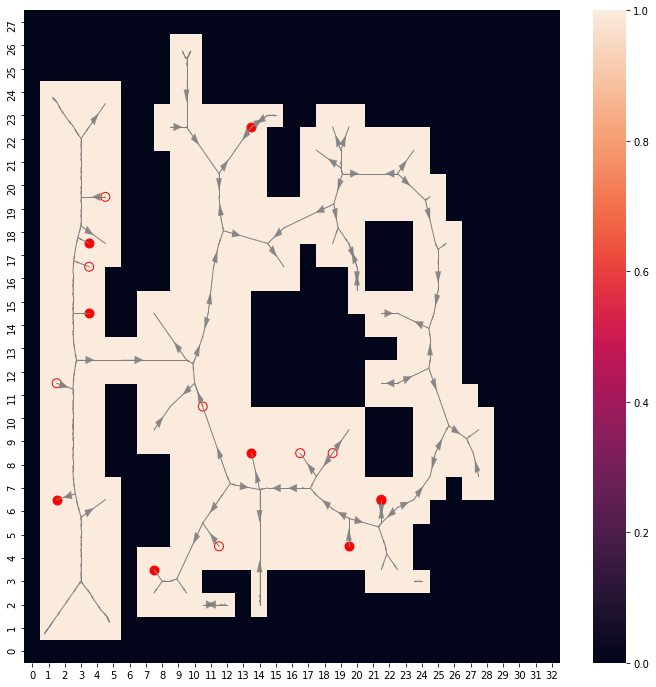

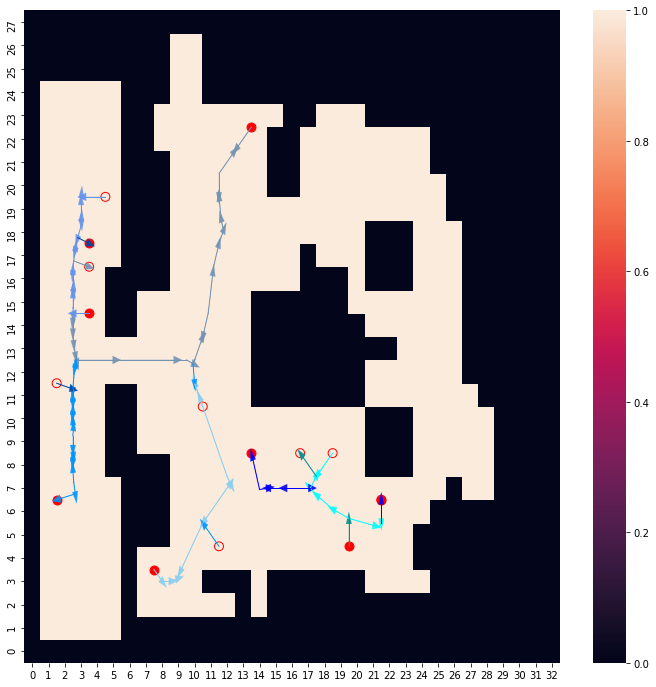

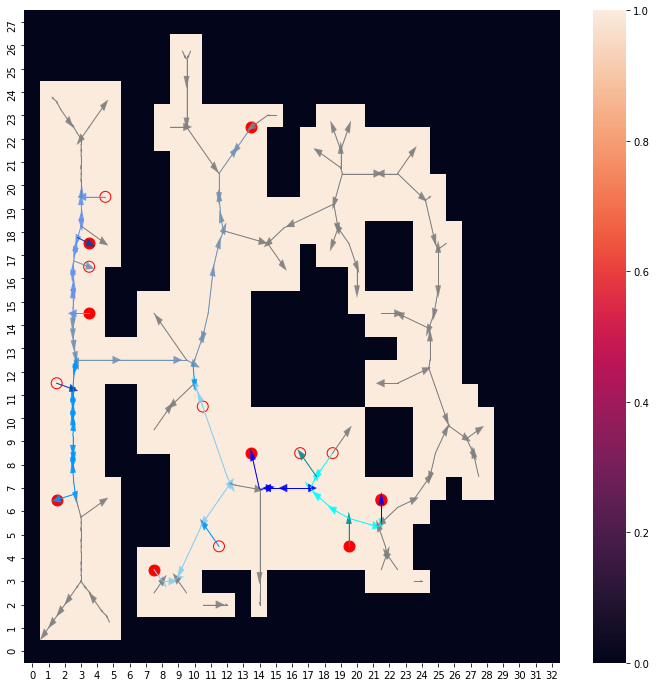

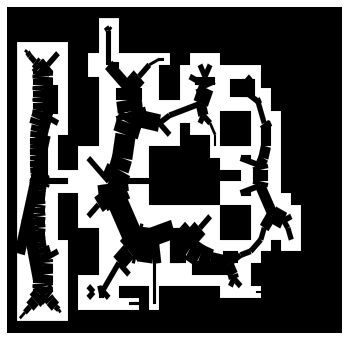

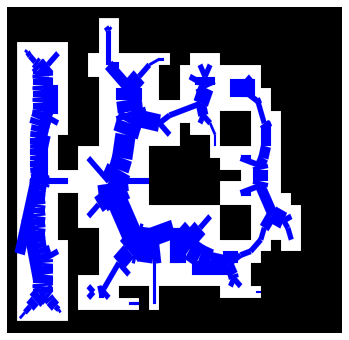

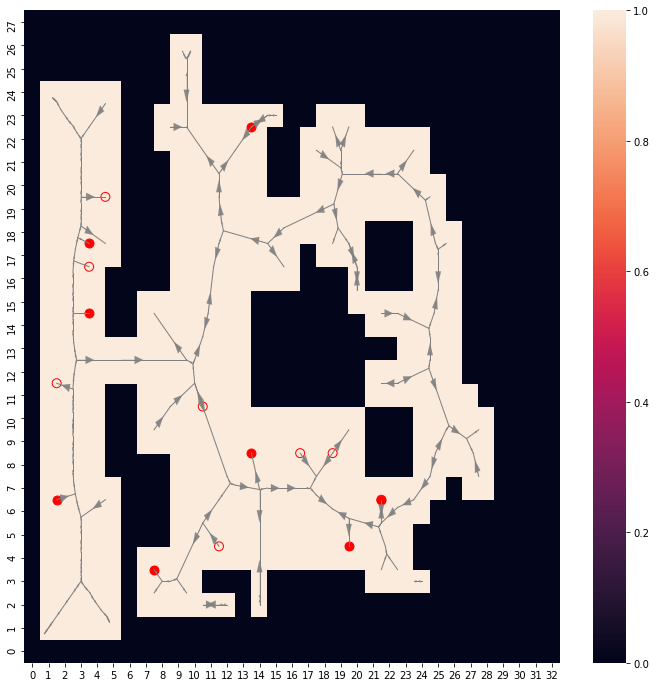

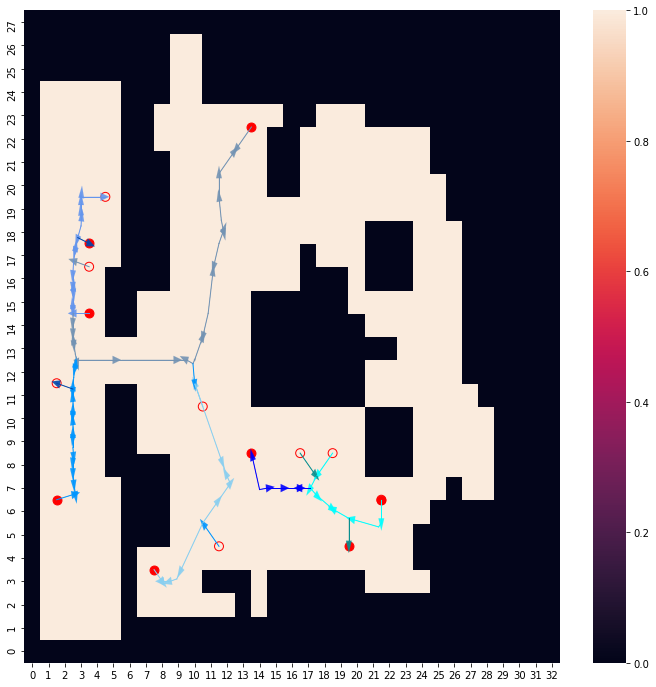

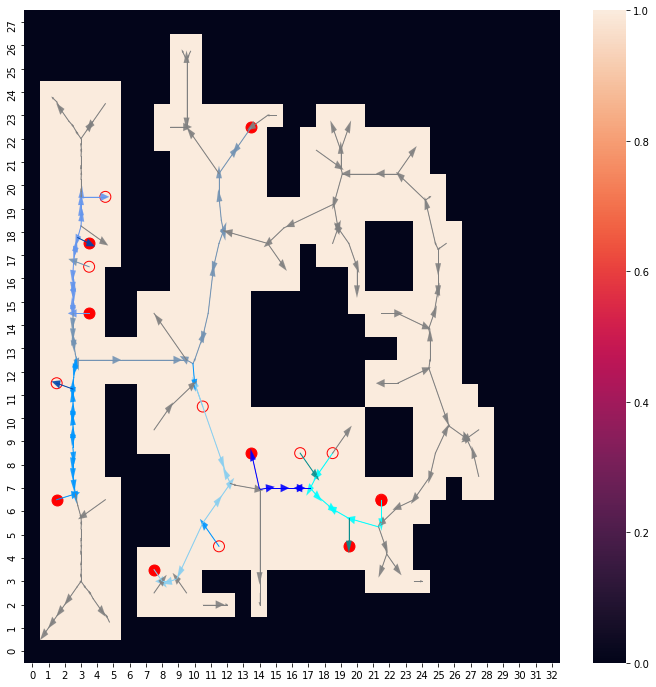

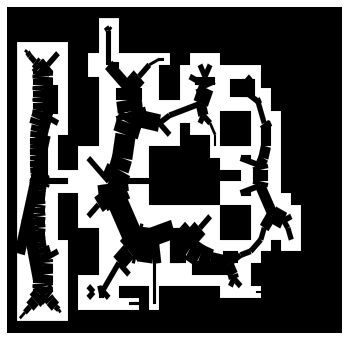

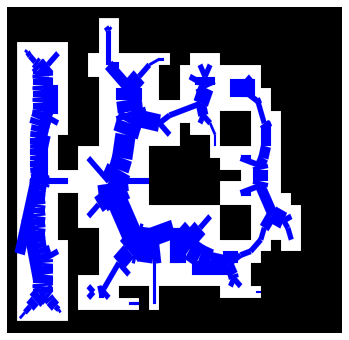

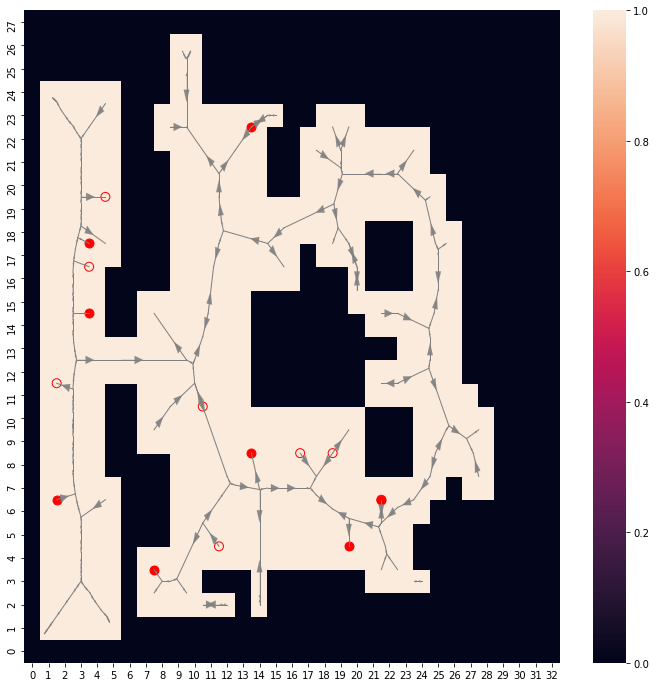

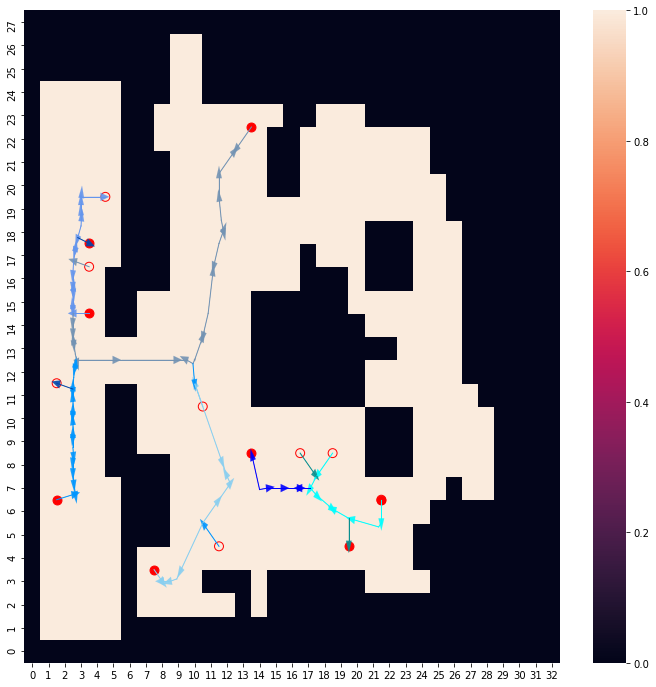

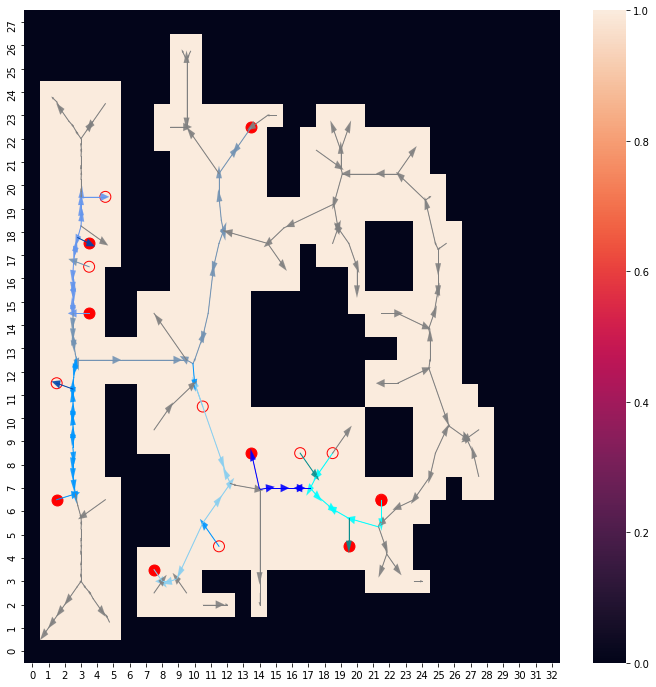

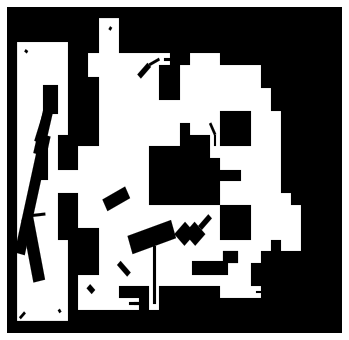

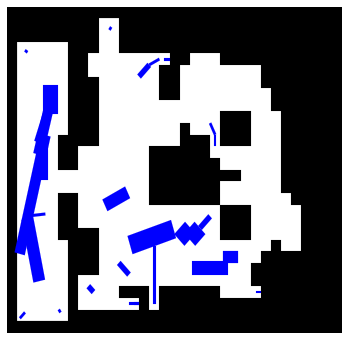

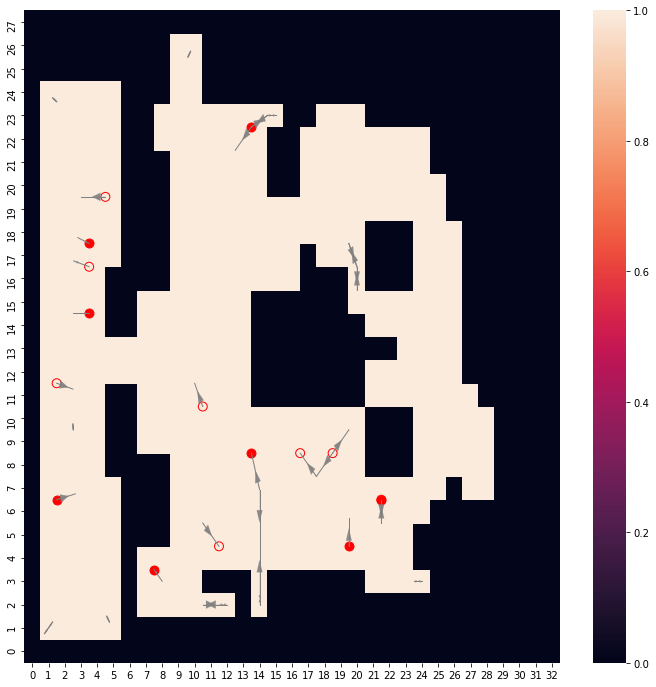

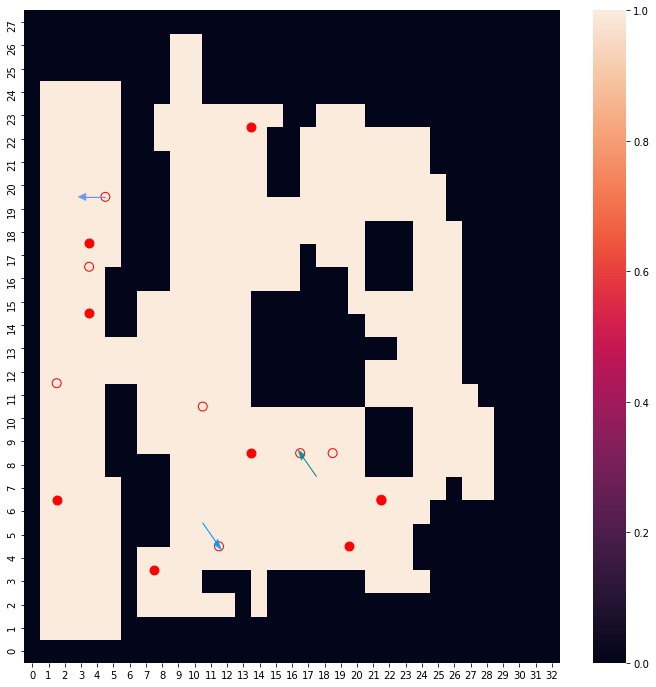

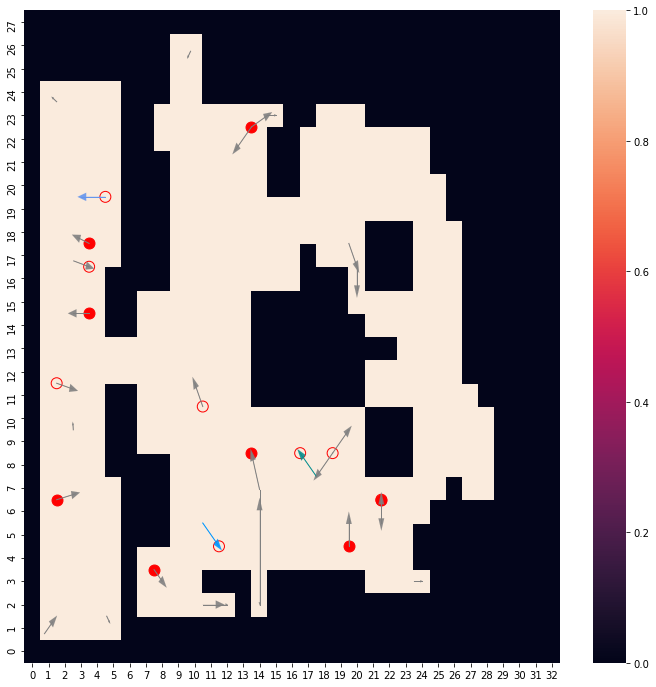

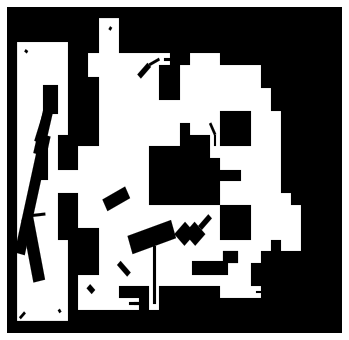

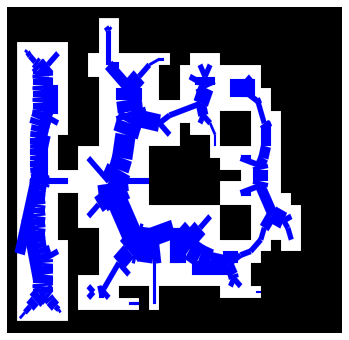

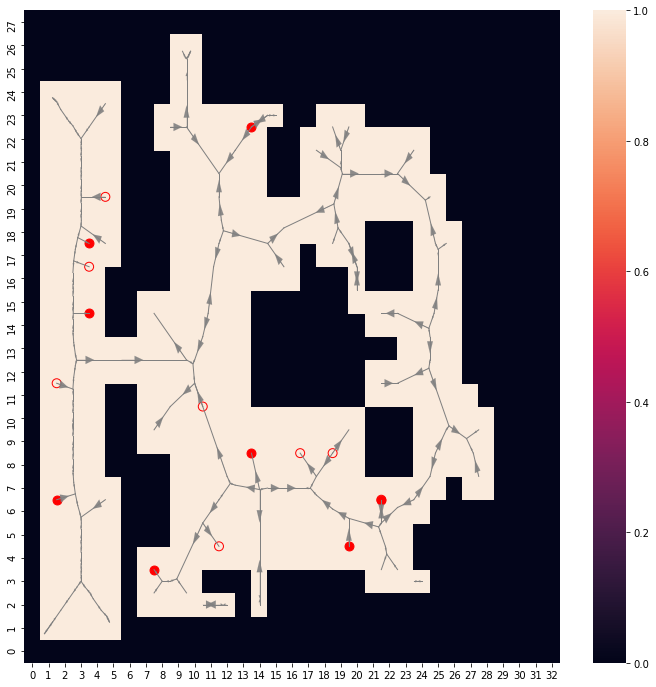

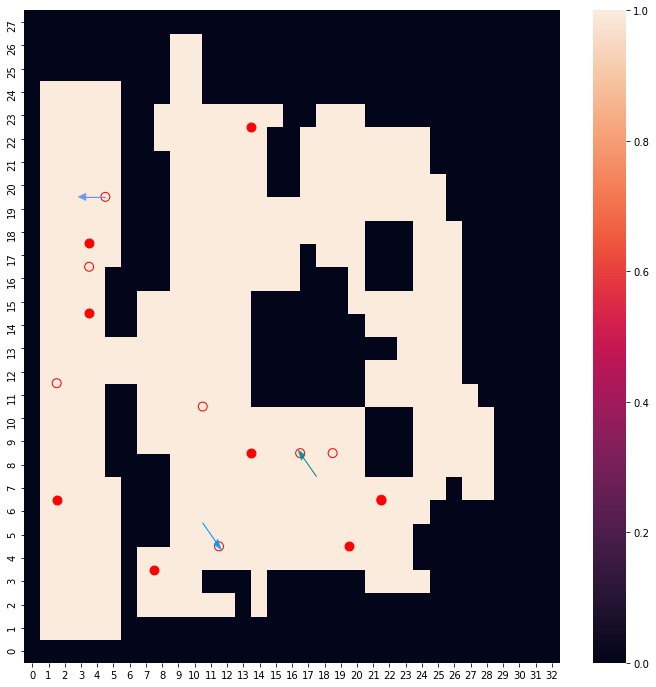

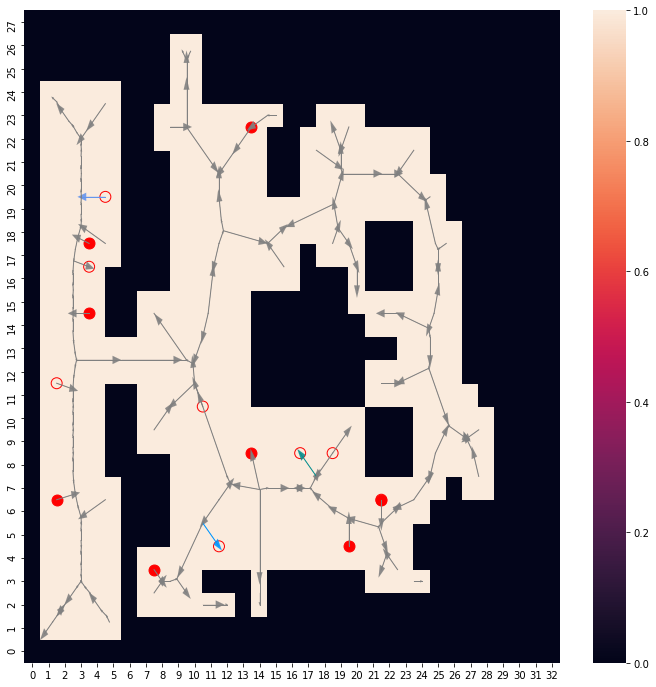

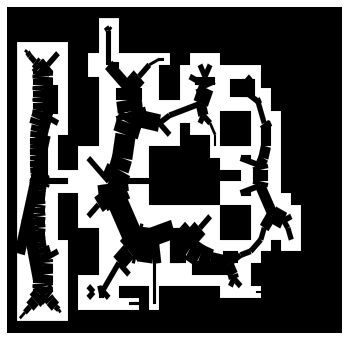

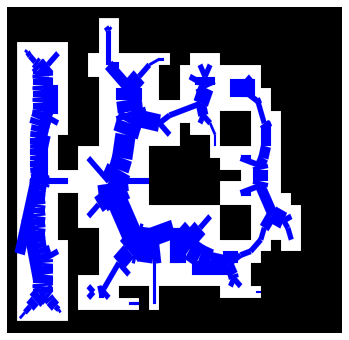

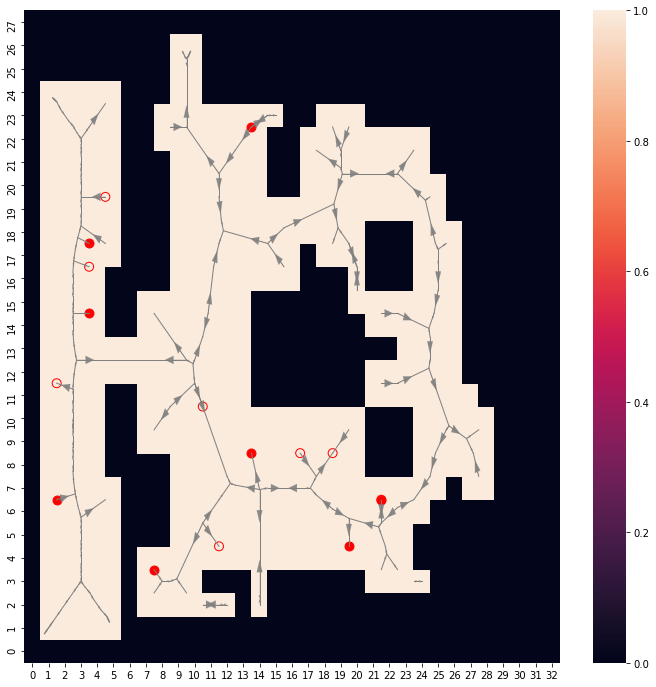

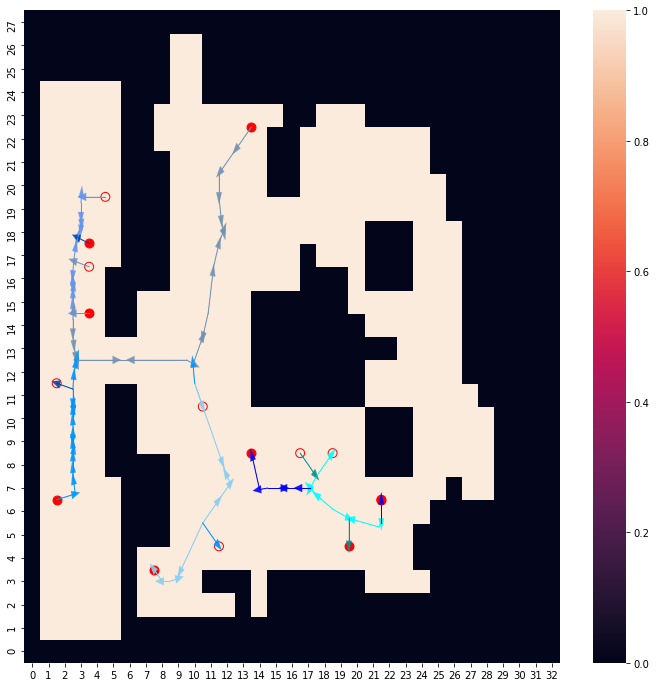

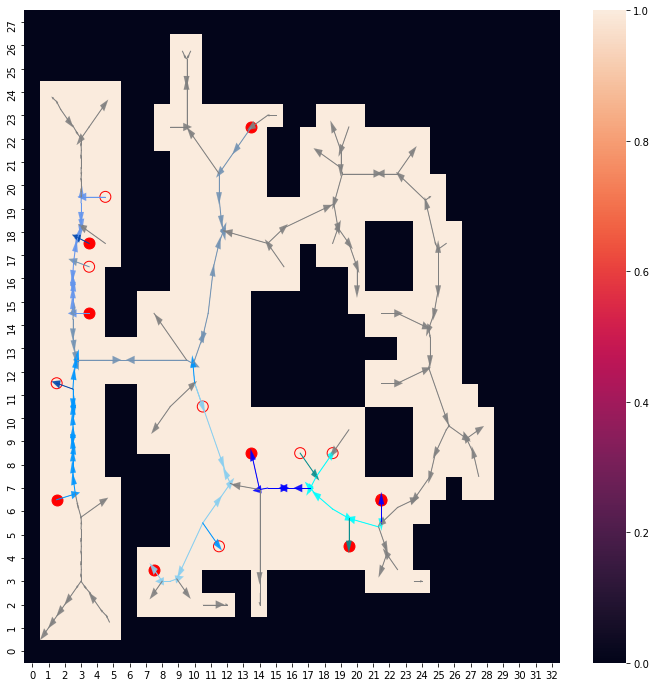

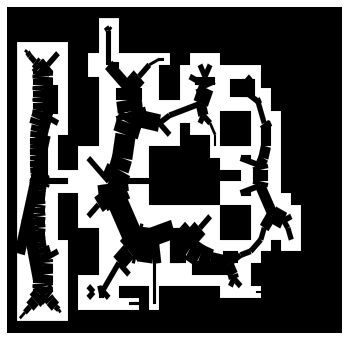

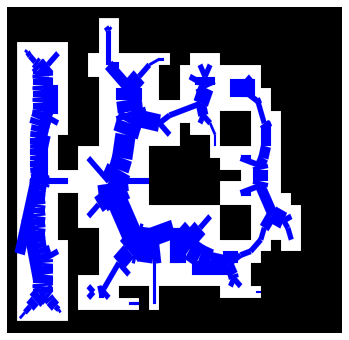

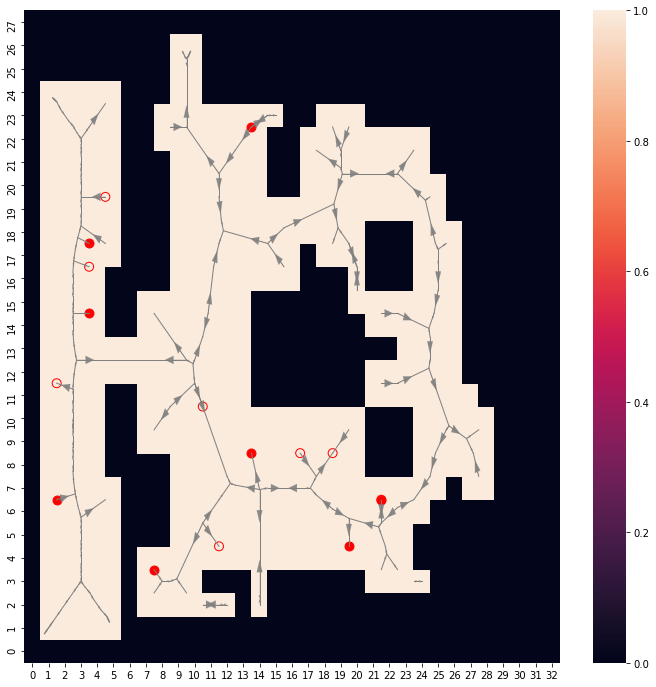

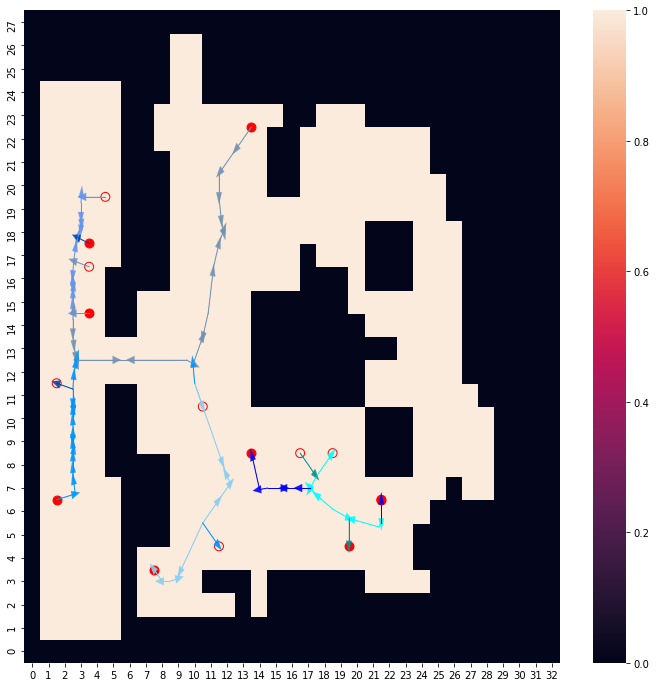

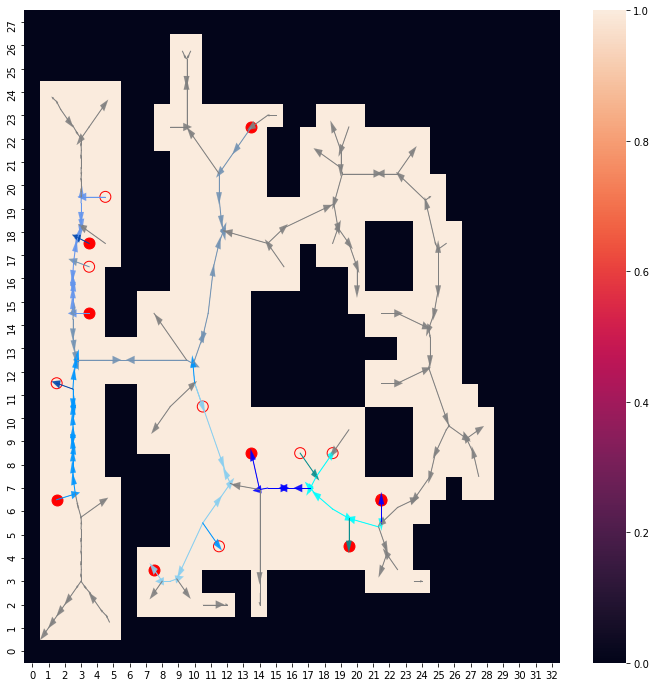

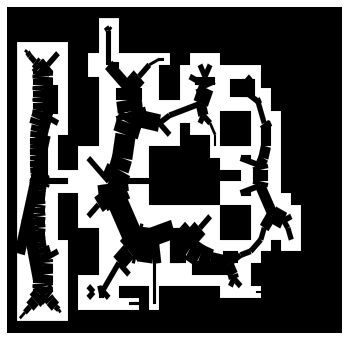

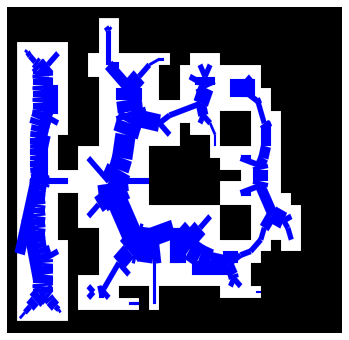

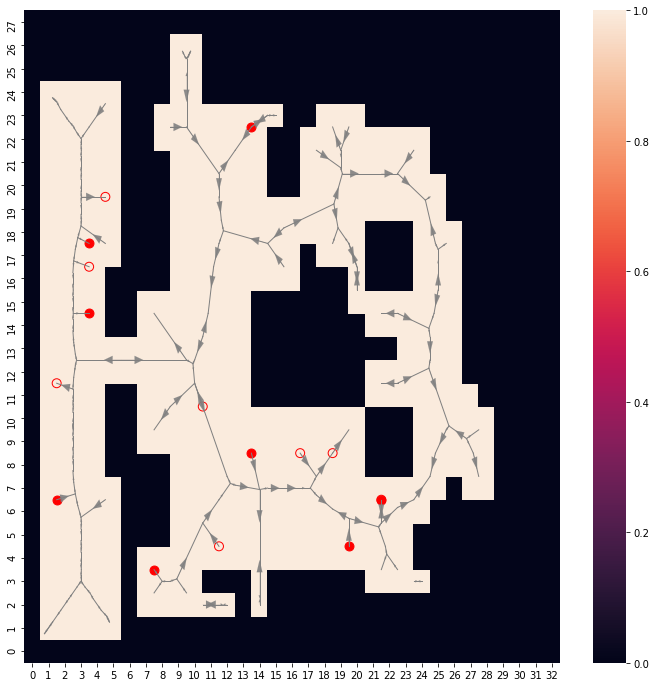

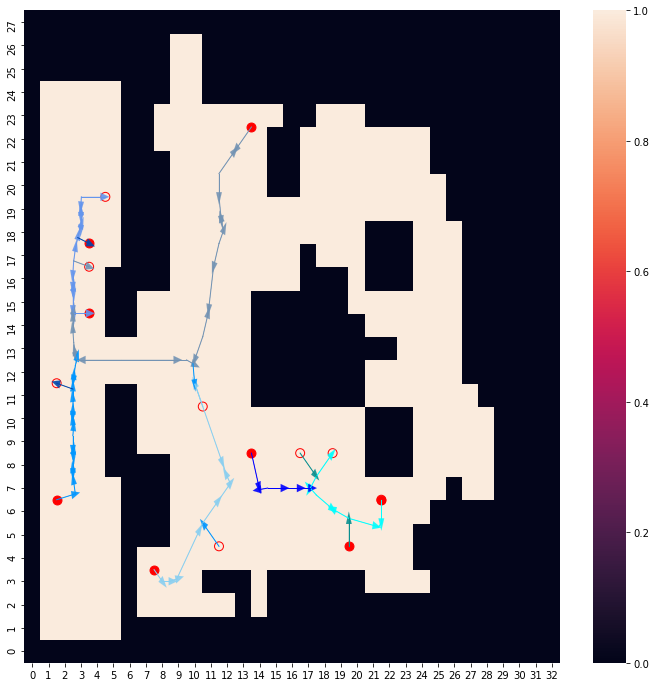

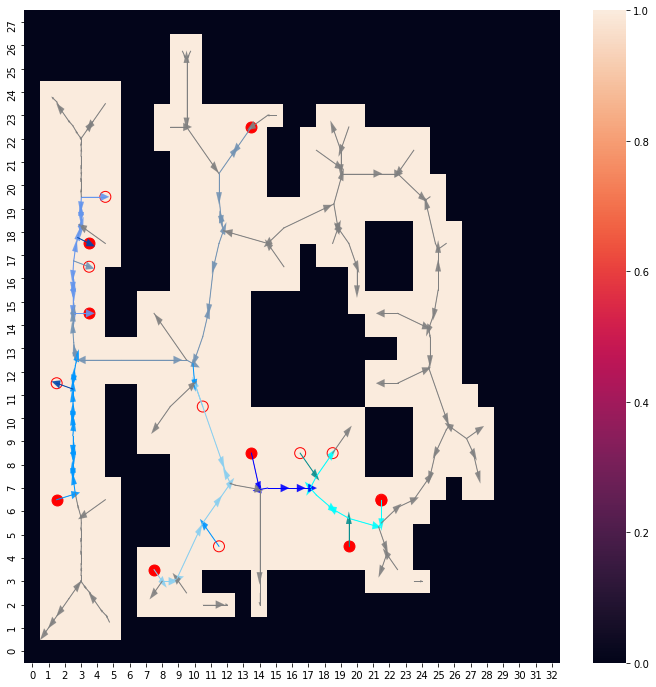

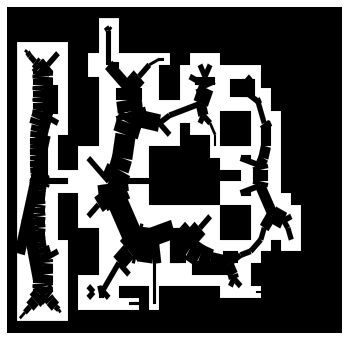

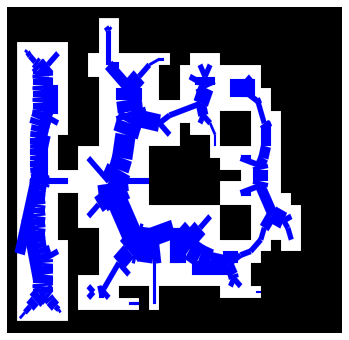

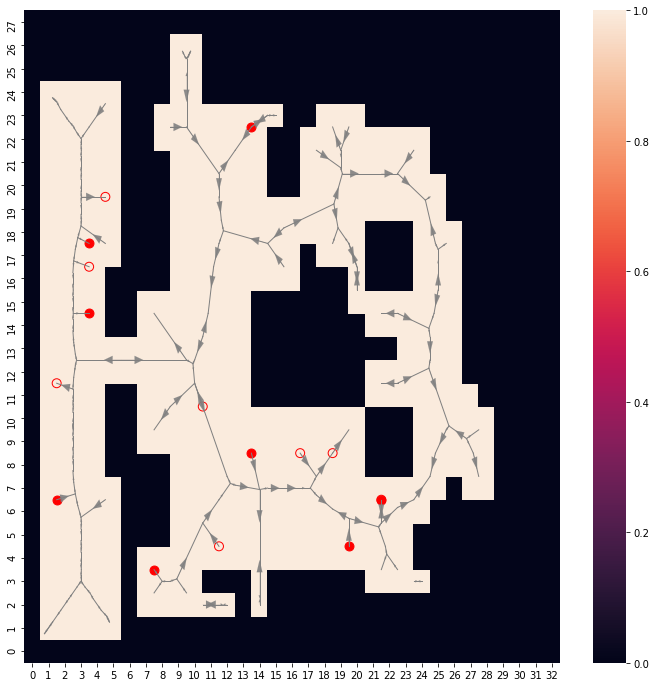

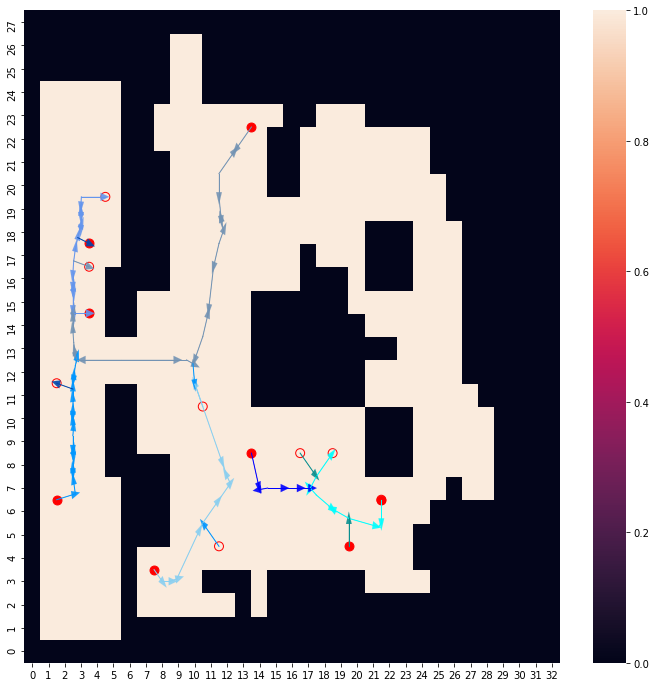

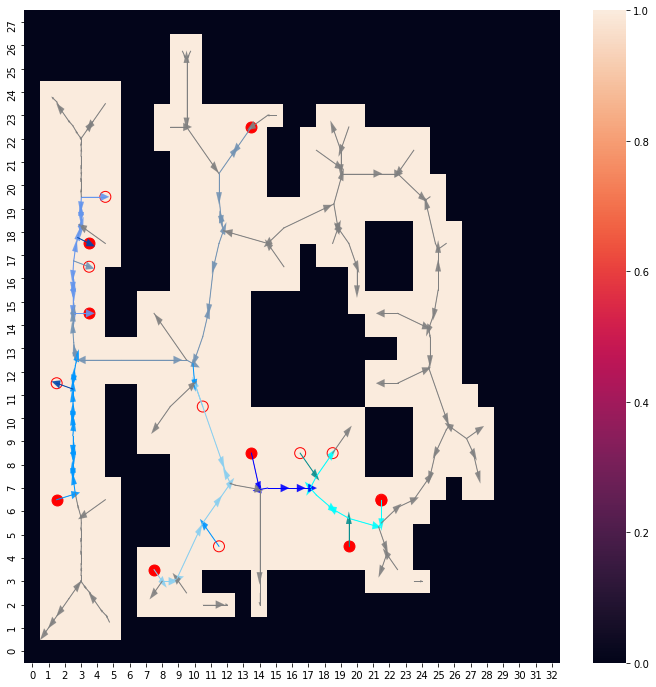

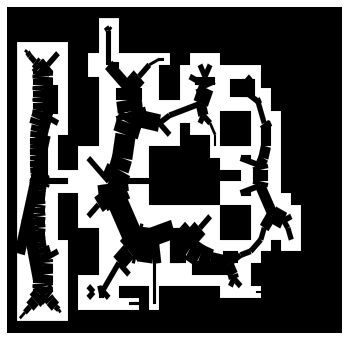

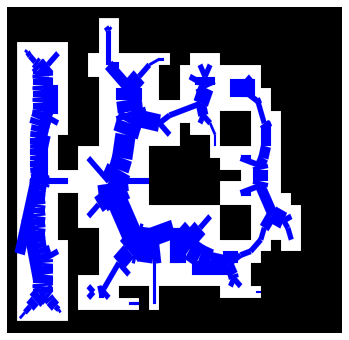

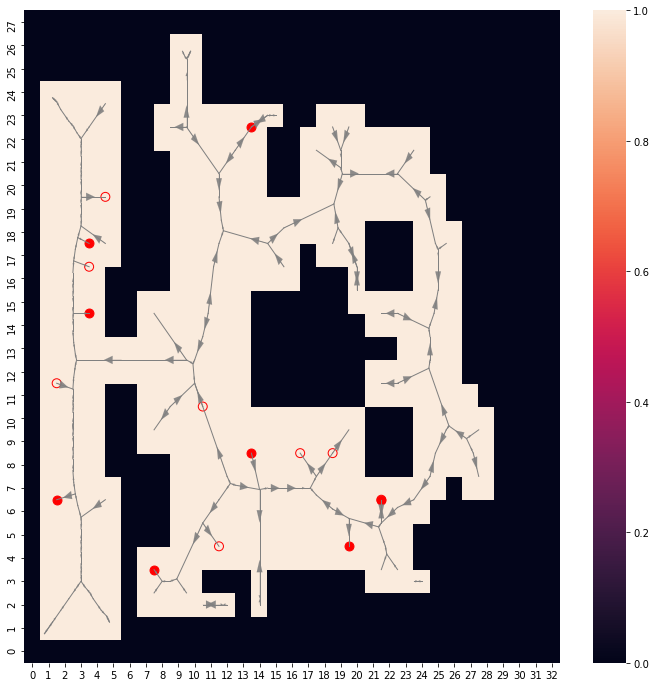

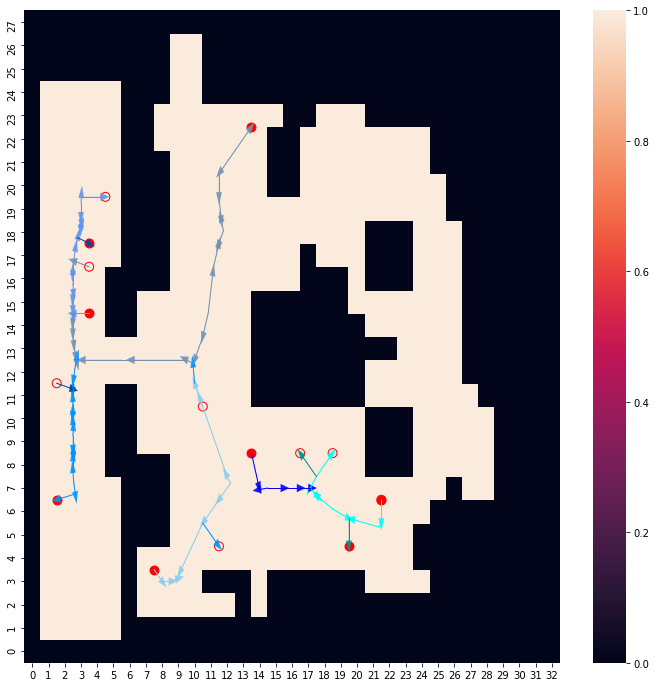

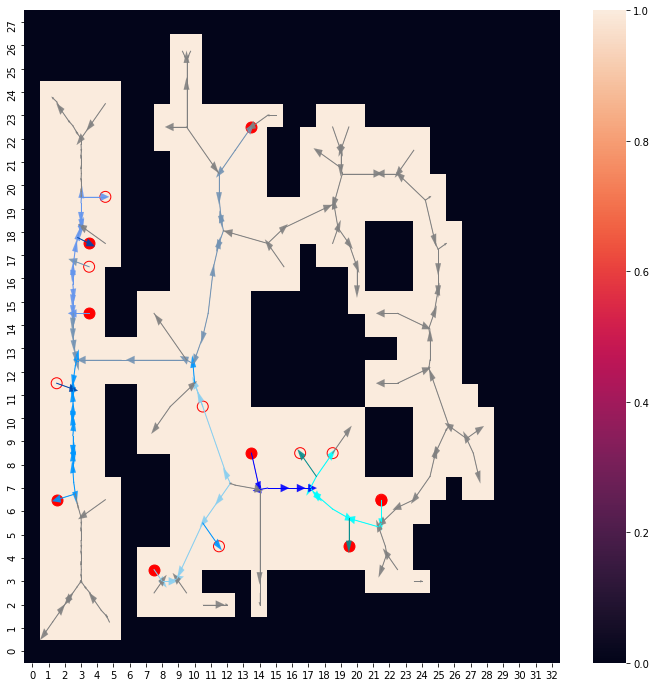

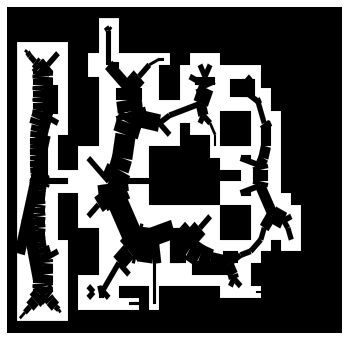

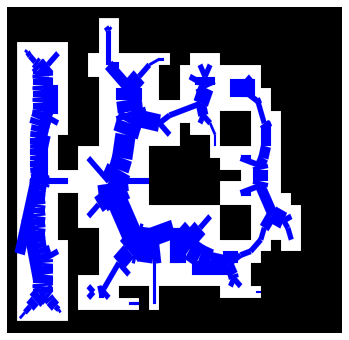

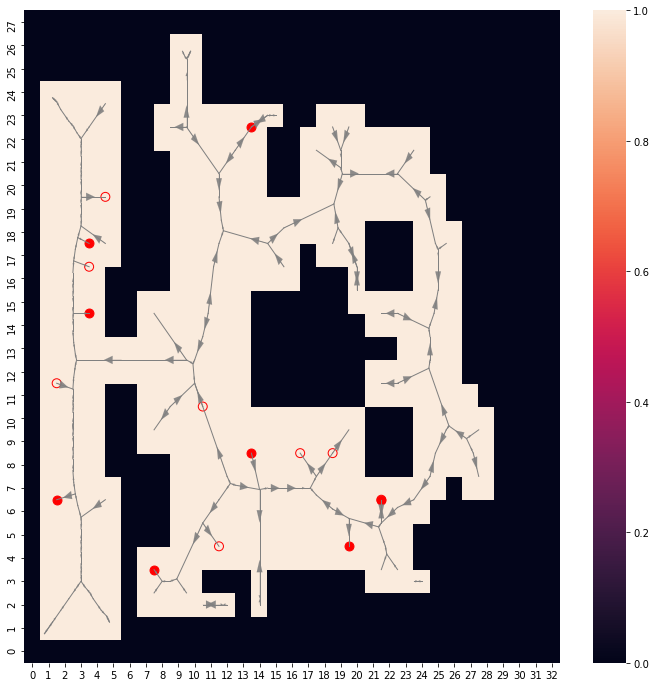

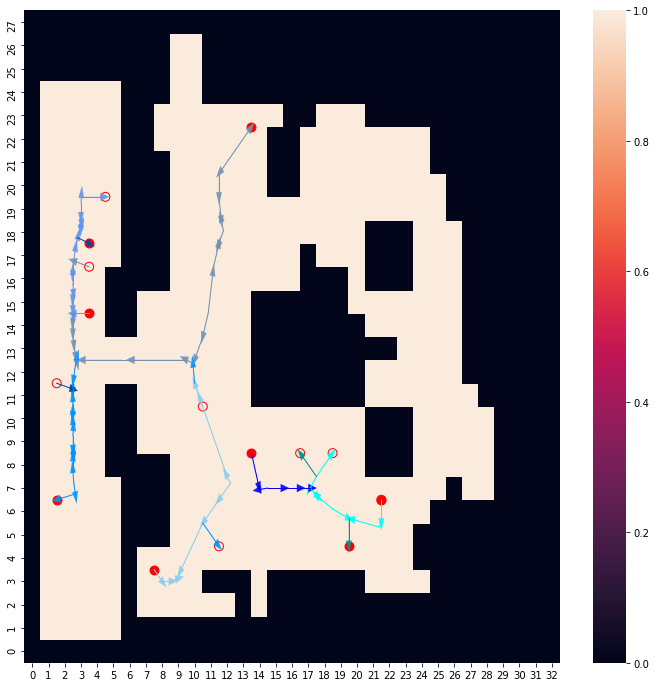

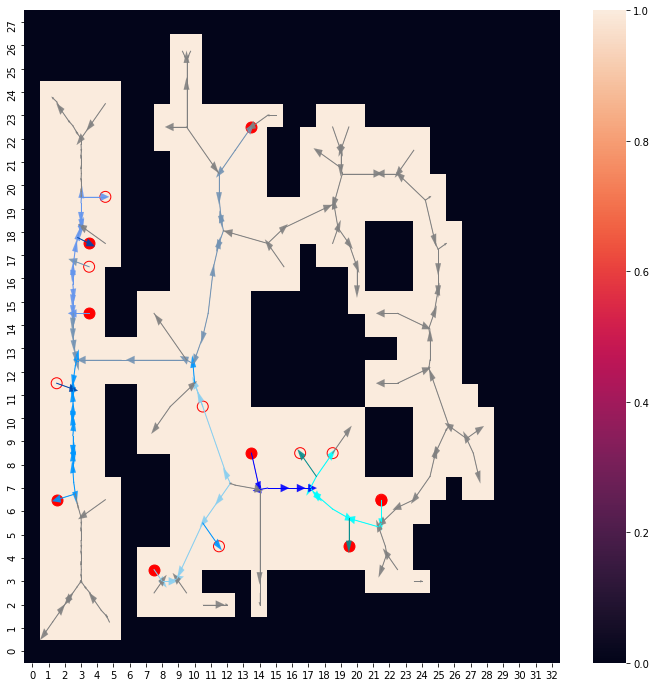

In [10]:
# sample_no_list =  [10, 50, 100, 500, 1000, 5000, 10000]
sample_no_list =  [10, 50, 100, 500, 1000, 5000]
agent_list = [4,8]
final_result_path =  "./data/ANN/final_result.csv"
time_path = "./data/ANN/TrainingData/gather_data_time.csv"
MAX_SUBGRAPH = 0.5

for NUM_AGENT in agent_list:
    for NUM_SAMPLE in sample_no_list:
        for DATASET in range (3,4,1):
            try:
                overall_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/"
                os.makedirs(overall_path)
            except OSError:
                print ("Creation of the directory %s failed" % overall_path)
            else:
                print ("Successfully created the directory %s " % overall_path)

            data_x_path = "./data/ANN/TrainingData/Dataset" + str(DATASET) + "-Agent" + str(NUM_AGENT) + "_x_path.csv"
            data_y_path = "./data/ANN/TrainingData/Dataset" + str(DATASET) + "-Agent" + str(NUM_AGENT) + "_y_path.csv"
            model_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/model/checkpoint"
            result_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/result.csv"
            result_fig_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/fig.png"
            
            vordir_fig_pathonly_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) +"/vordir_paths.png"
            vordir_fig_alledge_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_alledge.png"
            vordir_fig_acc_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_acc.png"
            vordir_fig_coverage_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_coverage.png"
            vordir_path_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_path.csv"
            vordir_probability_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_prob.csv"
            # without sub graph
            vordir2_fig_pathonly_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_paths.png"
            vordir2_fig_alledge_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_alledge.png"
            vordir2_fig_acc_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_acc.png"
            vordir2_fig_coverage_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_coverage.png"
            vordir2_path_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_path.csv"
            vordir2_probability_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_prob.csv"
            


            # Data Processing
            Y_read = pd.read_csv(data_y_path)
            y = Y_read.to_numpy()
            X_read = pd.read_csv(data_x_path)
            X = X_read.to_numpy()
            X = X.reshape((y.shape[0],-1))
            prob_sz = X.shape[1]
            
            y = y[:NUM_SAMPLE]
            X = X[:NUM_SAMPLE,:prob_sz]
            print("X shape", X.shape)

            x_train_temp, x_test, y_train_temp, y_test = train_test_split(
                X, y, test_size=0.1, random_state=4
            )
            x_train, x_val, y_train, y_val = train_test_split(
                x_train_temp, y_train_temp, test_size=0.11, random_state=4
            )

            scaler = MinMaxScaler()
            x_train_norm = scaler.fit_transform(x_train)
            y_train_norm = scaler.fit_transform(y_train)
            x_val_norm = scaler.fit_transform(x_val)
            y_val_norm = scaler.fit_transform(y_val)
            x_test_norm = scaler.fit_transform(x_test)
            y_test_norm = scaler.fit_transform(y_test)

            x_train_norm = x_train_norm.reshape((-1,1,prob_sz))
            x_test_norm = x_test_norm.reshape((-1,1,prob_sz))
            x_val_norm = x_val_norm.reshape((-1,1,prob_sz))

            # Model
            np.random.seed(42)
            tf.random.set_seed(42)
            model = keras.models.Sequential([
                Dense(units=128, activation='relu', kernel_initializer='normal', input_shape=(1,prob_sz)),
                Dropout(0.2),
                Dense(units=64, activation='relu',),
                Dropout(0.2),
                Dense(units=32, activation='relu',),
                Dropout(0.2),
                Dense(units=1, activation='sigmoid'),
            ])

            opt = keras.optimizers.Adam(learning_rate=1e-5)
            model.compile(
                loss="mean_squared_error", 
                optimizer=opt,
                metrics=["accuracy"])

            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=model_path,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)

            # Training
            start = time.time()
            history = model.fit(x_train_norm, 
                y_train_norm,
                batch_size = 32,
                epochs=100,
                validation_data=(x_val_norm, y_val_norm),
                callbacks=[model_checkpoint_callback],
                verbose=0)
            end = time.time()
            training_time = end - start



            model.load_weights(model_path)
            def run_nn(arr):
                arr = np.round(arr, 2)
                c = model.predict(arr.reshape(1,prob_sz))
                cost = scaler.inverse_transform(c)
                return cost[0]

            # Set Bound
            bnb = []
            for idx in range(prob_sz-3):
                bnb.append((0.0,1))

            bnb.append((-0.5,0.5))#c1
            bnb.append((0.25,0.75))#c2
            bnb.append((0,MAX_SUBGRAPH))#c2

            print("Start Optimiser")
            start = time.time()
            res = minimize(run_nn, x_train_norm[0].reshape((prob_sz)), 
                method='L-BFGS-B', jac=None, bounds= bnb, tol=None, callback=None, 
                options={'disp': None, 'maxcor': 10, 'ftol': 1.220446049250313, 
                'gtol': 1e-05, 'eps': 0.001, 'maxfun': 500, 
                'maxiter': 500, 'iprint': - 1, 'maxls': 20, 
                'finite_diff_rel_step': None})
            end = time.time()
            optimiser_time = end - start
            sample_end = time.time()
            pd.DataFrame(res.x).to_csv(result_path, index=None)

            print("Start Visualise")
#             # Visualise Results
#             probabilities = pd.read_csv(result_path)
#             probabilities = probabilities.to_numpy()
#             probabilities = probabilities.reshape((prob_sz))

#             output = ANNVoronoiDirected.get_results(probabilities, exp)
#             vordir_paths, vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_con, vordir_conmax, vordir_conavg, vordir_G0, vordir_G, vordir_thres, vordir_penality = output
#             vordir_u2 = getCoverage(exp,vordir_G, directed = True)
            
            scene = "./input/same_density/"+ mapp +'/dataset/'+str(DATASET)+'_'+ mapp + ".scen"
            scenemap = "./input/same_density/"+ mapp +'/'+ mapp + ".map"
            exp = experiment.Experiment(scenemap=scenemap, scene=scene, objective= OBJECTIVE, num_agent=NUM_AGENT)

            # Visualisation
            probabilities = pd.read_csv(result_path)
            probabilities = probabilities.to_numpy()
            probabilities = probabilities.reshape((prob_sz))
            vordir_m = probabilities[-3]
            vordir_c = probabilities[-2]
            output = ANNVoronoiDirected.get_results(probabilities, exp)
            vordir_paths, vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_conwait, vordir_conmax, vordir_conavg, vordir_G0, vordir_G, vordir_thres, vordir_penality = output
            
            with open(vordir_path_path, 'a+') as f:
                paths = [[idx, exp.nodes[t].x , exp.nodes[t].y] for idx, path in enumerate(vordir_paths) for t in path]
                paths_pd = pd.DataFrame(paths,columns=['Agent', 'X','Y'])
                pd.DataFrame(paths_pd).to_csv(f, index=None)
            with open(vordir_probability_path, 'a+') as f:
                pd.DataFrame(probabilities).to_csv(f, index=None)
                
            vordir_u2 = getCoverage(exp, vordir_G, directed = True)
            getCoverage(exp,vordir_G, directed = True, save_fig_path=vordir_fig_coverage_path)
            showVorDirSolution(vordir_G, vordir_paths, exp, save_fig_path = vordir_fig_alledge_path)
            showVorDirSolutionPath(vordir_G, 
                                    vordir_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir_fig_pathonly_path) #path_num variables is unused
            showVorDirSolutionAcc(vordir_G, 
                                    vordir_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir_fig_acc_path, 
                                    exp=exp)
            
            
            # Voronoi Directed Without subgraph
            probabilities2 = copy.deepcopy(probabilities)
            probabilities2[-1] = 0
            output2 = ANNVoronoiDirected.get_results(probabilities, exp)
            vordir2_paths, vordir2_cost, vordir2_ft, vordir2_u1, vordir2_u2, vordir2_conwait, vordir2_conmax, vordir2_conavg, vordir2_G0, vordir2_G, vordir2_thres, vordir2_penality = output2
            vordir2_u2 = getCoverage(exp,vordir_G, directed = True)
            with open(vordir2_path_path, 'a+') as f:
                paths = [[idx, exp.nodes[t].x , exp.nodes[t].y] for idx, path in enumerate(vordir2_paths) for t in path]
                paths_pd = pd.DataFrame(paths,columns=['Agent', 'X','Y'])
                pd.DataFrame(paths_pd).to_csv(f, index=None)
            with open(vordir2_probability_path, 'a+') as f:
                pd.DataFrame(probabilities2).to_csv(f, index=None)
            getCoverage(exp,vordir2_G0, directed = True, save_fig_path=vordir2_fig_coverage_path)
            showVorDirSolution(vordir2_G0, vordir2_paths, exp, save_fig_path = vordir2_fig_alledge_path)
            showVorDirSolutionPath(vordir2_G0, 
                                    vordir2_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir2_fig_pathonly_path) #path_num variables is unused
            showVorDirSolutionAcc(vordir2_G0, 
                                    vordir2_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir2_fig_acc_path, 
                                    exp=exp)
            
            
            #save_result
            gdt = pd.read_csv(time_path)
            gdt1 = gdt.loc[gdt['NUM_AGENT']==str(NUM_AGENT)]
            gdt2 = gdt1.loc[gdt1['DATASET']==str(DATASET)]
            gather_data_time = float(gdt2['gather_data_time'])*NUM_SAMPLE/10000
            computational_time = gather_data_time+training_time+optimiser_time
            results = [NUM_AGENT, NUM_SAMPLE, DATASET, vordir_cost, 
                       vordir_ft, vordir_u1, vordir_u2, vordir_penality,
                       vordir_conwait, vordir_conmax, vordir_thres, vordir_m, vordir_c,
                       vordir2_cost, vordir2_ft, vordir2_u1, vordir2_u2, vordir2_conwait, vordir2_conmax, vordir2_penality,
                       computational_time, gather_data_time, training_time, optimiser_time]
            
            results_array.append(results)
            result_pd = pd.DataFrame([results],columns=['Agent','Samples','Dataset','vordir_cost',
                                                        'vordir_ft', 'vordir_u1', 'vordir_u2', 'vordir_penality',
                                                        'vordir_conwait', 'vordir_conmax', 'vordir_thres', 'vordir_m', 'vordir_c',
                                                        'vordir2_cost', 'vordir2_ft', 'vordir2_u1', 'vordir2_u2', 'vordir2_conwait', 'vordir2_conmax', 'vordir2_penality',
                                                        'Time', 'gather_data_time', 'training_time', 'optimiser_time'])
            
            with open(final_result_path, 'a+') as f:
                pd.DataFrame(result_pd).to_csv(f, index=None)

### Slicing the dataset to test different model archetiture

In [ ]:
# TODO

In [ ]:
# # sample_no_list =  [10]
# sample_no_list =  [10, 50, 100, 500, 1000, 5000, 10000]
# agent_list = [4,8,12]

# for NUM_AGENT in agent_list:
#     final_result_path =  "./data/ANN/"+str(NUM_AGENT)+"agent/final_result.csv"
#     for NUM_SAMPLE in sample_no_list:
#         for DATASET in range (1,6,1):
#             try:
#                 overall_path = "./data/ANN/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/"
#                 os.makedirs(overall_path)
#             except OSError:
#                 print ("Creation of the directory %s failed" % overall_path)
#             else:
#                 print ("Successfully created the directory %s " % overall_path)

#             sample_start = time.time()
#             data_x_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/x_path.csv"
#             data_y_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/y_path.csv"
#             model_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/model/checkpoint"
#             result_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/result.csv"
#             result_fig_path = "./data/ANN/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/fig.png"

#             scenemap = "./input/random-32-32-10/random-32-32-10.map"
#             scene = "./input/random-32-32-10/scen-even/random-32-32-10-even-" + str(DATASET) + ".scen"
#             exp = experiment.Experiment(scenemap=scenemap, scene=scene, objective=OBJECTIVE, num_agent=NUM_AGENT)


#             start = time.time()
#             ANNVoronoiDirected.ann_voronoi_directed(exp, dataset=DATASET, num_sample = NUM_SAMPLE)
#             end = time.time()
#             gather_data_time = end-start
#             print("Finish generating data")

#             # Data Processing
#             Y_read = pd.read_csv(data_y_path)
#             y = Y_read.to_numpy()

#             X_read = pd.read_csv(data_x_path)
#             X = X_read.to_numpy()
#             X = X.reshape((y.shape[0],-1))
#             prob_sz = X.shape[1]

#             x_train_temp, x_test, y_train_temp, y_test = train_test_split(
#                 X, y, test_size=0.1, random_state=4
#             )
#             x_train, x_val, y_train, y_val = train_test_split(
#                 x_train_temp, y_train_temp, test_size=0.11, random_state=4
#             )

#             scaler = MinMaxScaler()
#             x_train_norm = scaler.fit_transform(x_train)
#             y_train_norm = scaler.fit_transform(y_train)
#             x_val_norm = scaler.fit_transform(x_val)
#             y_val_norm = scaler.fit_transform(y_val)
#             x_test_norm = scaler.fit_transform(x_test)
#             y_test_norm = scaler.fit_transform(y_test)

#             x_train_norm = x_train_norm.reshape((-1,1,prob_sz))
#             x_test_norm = x_test_norm.reshape((-1,1,prob_sz))
#             x_val_norm = x_val_norm.reshape((-1,1,prob_sz))

#             # Model
#             np.random.seed(42)
#             tf.random.set_seed(42)
#             model = keras.models.Sequential([
#                 Dense(units=512, activation='relu', kernel_initializer='normal', input_shape=(1,prob_sz)),
#                 Dropout(0.2),
#                 Dense(units=256, activation='relu',),
#                 Dropout(0.2),
#                 Dense(units=128, activation='relu',),
#                 Dropout(0.2),
#                 Dense(units=1, activation='sigmoid'),
#             ])

#             opt = keras.optimizers.Adam(learning_rate=1e-5)
#             model.compile(
#                 loss="mean_squared_error", 
#                 optimizer=opt,
#                 metrics=["accuracy"])

#             model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#                 filepath=model_path,
#                 save_weights_only=True,
#                 monitor='loss',
#                 mode='min',
#                 save_best_only=True)

#             # Training
#             start = time.time()
#             history = model.fit(x_train_norm, 
#                 y_train_norm,
#                 batch_size = 32,
#                 epochs=100,
#                 validation_data=(x_val_norm, y_val_norm),
#                 callbacks=[model_checkpoint_callback],
#                 verbose=0)
#             end = time.time()
#             training_time = end - start



#             model.load_weights(model_path)
#             def run_nn(arr):
#                 arr = np.round(arr, 2)
#                 c = model.predict(arr.reshape(1,prob_sz))
#                 cost = scaler.inverse_transform(c)
#                 return cost[0]

#             # Set Bound
#             bnb = []
#             for idx in range(prob_sz-3):
#                 bnb.append((0.0,1))

#             bnb.append((-0.5,0.5))#c1
#             bnb.append((0.25,0.75))#c2
#             bnb.append((0,0.1))#c2

#             print("Start Optimiser")
#             start = time.time()
#             res = minimize(run_nn, x_train_norm[0].reshape((prob_sz)), 
#                 method='L-BFGS-B', jac=None, bounds= bnb, tol=None, callback=None, 
#                 options={'disp': None, 'maxcor': 10, 'ftol': 1.220446049250313, 
#                 'gtol': 1e-05, 'eps': 0.001, 'maxfun': 500, 
#                 'maxiter': 500, 'iprint': - 1, 'maxls': 20, 
#                 'finite_diff_rel_step': None})
#             end = time.time()
#             optimiser_time = end - start
#             sample_end = time.time()
#             pd.DataFrame(res.x).to_csv(result_path, index=None)

#             print("Start Visualise")
#             # Visualise Results
#             probabilities = pd.read_csv(result_path)
#             probabilities = probabilities.to_numpy()
#             probabilities = probabilities.reshape((prob_sz))

#             output = ANNVoronoiDirected.get_results(probabilities, exp)
#             vordir_paths, vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_con, vordir_conmax, vordir_conavg, vordir_G0, vordir_G, vordir_thres, vordir_penality = output
#             vordir_u2 = getCoverage(exp,vordir_G, directed = True)

#             #save_result
#             computational_time = sample_end - sample_start
#             results = [NUM_SAMPLE, DATASET, vordir_cost, 
#                        vordir_ft, vordir_u1, vordir_u2, 
#                        vordir_conmax, vordir_conavg, vordir_thres, vordir_penality,
#                        computational_time, gather_data_time, training_time, optimiser_time]
#             results_array.append(results)
#             result_pd = pd.DataFrame([results],columns=['Samples','Dataset','cost',
#                                                               'vordir_ft','vordir_u1','vordir_u2',
#                                                               'vordir_max', 'vordir_avg','subgraph','Penality', 
#                                                               'Time', 'gather_data_time', 'training_time', 'optimiser_time'])
#             with open(final_result_path, 'a+') as f:
#                 pd.DataFrame(result_pd).to_csv(f, index=None)

#             showAccSolution(vordir_G0, 
#                             vordir_paths, 
#                             exp.image, 
#                             exp.nodes, 
#                             exp.start_nodes, 
#                             exp.end_nodes, 
#                             all_path = False, 
#                             path_num = 0,
#                             save_fig_path = result_fig_path) #path_num variables is unused



In [ ]:
# pd.DataFrame(results_array,columns=['Samples','Dataset','cost',
#                                       'vordir_ft','vordir_u1','vordir_u2',
#                                       'vordir_max', 'vordir_avg','subgraph','Penality', 
#                                       'Time', 'gather_data_time', 'training_time', 'optimiser_time'])

In [ ]:
# pd.DataFrame(results_array,columns=['Samples','Dataset','cost',
#                                       'vordir_ft','vordir_u1','vordir_u2',
#                                       'vordir_max', 'vordir_avg','subgraph', 
#                                       'Time', 'gather_data_time', 'training_time', 'optimiser_time'])